# 資料

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
from pathlib import Path
# 資料路徑設定
# path_vol_dir = Path(r"/content/drive/MyDrive/實驗資料/秒_資料/波動/parquet")
path_vol_dir = Path(r"C:\Users\user\OneDrive - National Pingtung University\code\data\秒_資料\波動\parquet")
OUT = Path("./output_v全域版")
OUT.mkdir(exist_ok=True, parents=True)

In [3]:
# @title
# ============================================================
# Cell 1: 參數設定 + 工具函數
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import gc

from datetime import date, datetime
import numpy as np
import polars as pl
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import seaborn as sns

# --- 全域參數設定 ---
FREQ = "1m"
WINDOW_R = 5
WINDOW_E = 15
EPSILON = 1e-6

# 清洗設定
MIN_VOL_THRESHOLD = 5.0      # 死魚盤過濾：總量小於此數值視為無效
MAX_RET_THRESHOLD = 0.1      # 異常波動過濾：單分鐘漲跌幅超過 10% 視為異常數據



# --- Logging 工具 ---
def log(msg):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] 🔹 {msg}")

# --- 日期解析工具 ---
def get_short_long_labels(fdate):
    """判斷週三與週五結算日的標籤映射"""
    wd = fdate.weekday()
    if wd in (0, 1): return ("Wed", "Fri") # 週一、週二 -> 近:Wed, 遠:Fri
    if wd in (2, 3): return ("Fri", "Wed") # 週三、週四 -> 近:Fri, 遠:Wed (週三換倉後)
    if wd == 4:      return ("Fri", "Wed") # 週五
    raise ValueError(f"非交易日或無法判斷: {fdate} (weekday={wd})")

def parse_date(stem):
    """
    從檔名解析日期
    修正邏輯：針對 MMDD 格式，若月份 < 9，自動視為 2026 年，否則為 2025 年。
    """
    try:
        # 嘗試直接解析 YYYY-MM-DD
        return datetime.strptime(stem, "%Y-%m-%d").date()
    except:
        pass

    # 備用方案：抓取檔名中的數字
    digits = "".join([c for c in stem if c.isdigit()])

    # 格式 1: YYYYMMDD (8碼)
    if len(digits) == 8:
        return date(int(digits[:4]), int(digits[4:6]), int(digits[6:]))

    # 格式 2: MMDD (4碼) -> 需判斷年份
    if len(digits) == 4:
        month = int(digits[:2])
        day = int(digits[2:])

        # 🔧 邏輯修正：假設資料從 2025/09 開始
        # 如果月份是 1~8月，判定為跨年後的 2026
        # 如果月份是 9~12月，判定為 2025
        year = 2026 if month < 9 else 2025

        return date(year, month, day)

    return None

# --- Polars 數值處理工具 ---
def safe_log_diff(col_name):
    """計算 Log Return，並處理 Log(0) 與 Inf 問題"""
    return (
        pl.when(pl.col(col_name) <= EPSILON)
        .then(EPSILON)
        .otherwise(pl.col(col_name))
        .log()
        .diff()
        .fill_nan(0.0)
        .fill_null(0.0)
    )

# --- 單日處理函數 ---
def process_single_day(fp):
    """讀取並處理單日 Parquet 檔案"""
    try:
        fdate = parse_date(fp.stem)
        if fdate is None:
            return None

        # 讀取檔案
        df_vol = pl.read_parquet(fp)

        # 統一欄位名稱
        if "時間" in df_vol.columns:
            df_vol = df_vol.rename({"時間": "SnapshotTime"})

        # 確保必要欄位存在
        required_cols = ["現貨", "權值股_總瞬間量", "權值股_買進", "權值股_賣出"]
        if not all(col in df_vol.columns for col in required_cols):
            return None

        # 聚合為 K 棒 (Resample)
        q = (
            df_vol.lazy()
            .group_by_dynamic("SnapshotTime", every=FREQ)
            .agg([
                pl.col("現貨").last().alias("Price"),
                pl.col("Wed_Call波動").last().alias("Wed_Call"),
                pl.col("Wed_Put波動").last().alias("Wed_Put"),
                pl.col("Fri_Call波動").last().alias("Fri_Call"),
                pl.col("Fri_Put波動").last().alias("Fri_Put"),
                pl.col("權值股_總瞬間量").sum().alias("Vol_Total"),
                pl.col("權值股_買進").sum().alias("Vol_Buy"),
                pl.col("權值股_賣出").sum().alias("Vol_Sell"),
            ])
            .filter(
                (pl.col("SnapshotTime").dt.time() >= pl.time(8, 45)) &
                (pl.col("SnapshotTime").dt.time() <= pl.time(13, 45))
            )
        )

        df_agg = q.collect()
        if df_agg.is_empty():
            return None

        # 取得期權標籤 (近月/遠月)
        try:
            short, long = get_short_long_labels(fdate)
        except ValueError:
            return None

        def vc(day, cp): return f"{day}_{cp}"

        df_agg = df_agg.with_columns([
            safe_log_diff("Price").alias("Ret_t"),
            safe_log_diff(vc(short, "Call")).alias("Emo_Short_Call_diff"),
            safe_log_diff(vc(short, "Put")).alias("Emo_Short_Put_diff"),
            safe_log_diff(vc(long, "Call")).alias("Emo_Long_Call_diff"),
            safe_log_diff(vc(long, "Put")).alias("Emo_Long_Put_diff"),
            pl.lit(fdate).alias("date_group")
        ])

        keep_cols = [
            "SnapshotTime", "date_group", "Price", "Vol_Total", "Vol_Buy", "Vol_Sell",
            "Ret_t", "Emo_Short_Call_diff", "Emo_Short_Put_diff",
            "Emo_Long_Call_diff", "Emo_Long_Put_diff"
        ]
        return df_agg.select([c for c in keep_cols if c in df_agg.columns])

    except Exception as e:
        log(f"處理檔案 {fp.name} 時發生錯誤: {e}")
        return None


# ============================================================
# Cell 2: 特徵工程函數
# ============================================================

def perform_feature_engineering(df):
    """
    分階段構建特徵工程：
    1️⃣ 資金動向 (Buy_pressure_t)
    2️⃣ 滾動 ICA 情緒因子
    3️⃣ 價格特徵
    """
    log("開始執行特徵工程...")

    # ==========================================================
    # 1️⃣ 資金動向
    # ==========================================================
    log("執行 1️⃣ 資金動向特徵...")

    df = df.sort(["date_group", "SnapshotTime"])
    df = df.filter(
        (pl.col("Vol_Total") >= MIN_VOL_THRESHOLD) &
        (pl.col("Ret_t").abs() <= MAX_RET_THRESHOLD)
    )

    df = df.with_columns([
        ((pl.col("Vol_Buy") - pl.col("Vol_Sell")) /
         (pl.col("Vol_Buy") + pl.col("Vol_Sell") + 1))
        .alias("Buy_pressure_t")
    ])

    # 雙重平滑（長期意圖）
    df = df.with_columns([
        pl.col("Buy_pressure_t")
          .ewm_mean(span=30, adjust=False)
          .ewm_mean(span=30, adjust=False)
          .alias("Buy_pressure_trend_30m"),

        pl.col("Buy_pressure_t")
          .ewm_mean(span=60, adjust=False)
          .ewm_mean(span=60, adjust=False)
          .alias("Buy_pressure_trend_60m"),
    ])

    # ==========================================================
    # 2️⃣ 滾動 ICA 情緒因子
    # ==========================================================
    log("執行 2️⃣ 滾動 ICA（情緒因子萃取）")

    emo_cols = [
        "Emo_Short_Call_diff",
        "Emo_Short_Put_diff",
        "Emo_Long_Call_diff",
        "Emo_Long_Put_diff"
    ]

    unique_dates = sorted(df["date_group"].unique().to_list())
    df = df.with_columns(pl.lit(0.0).alias("Emo_score"))

    results = []
    ica_window_size = 10  # 滾動窗口：過去 10 個交易日

    for i, d in enumerate(unique_dates):
        # 構建訓練集：過去 ica_window_size 個日期 + 當前日期
        train_dates = unique_dates[max(0, i - ica_window_size): i + 1]

        df_train = df.filter(pl.col("date_group").is_in(train_dates))
        df_cur = df.filter(pl.col("date_group") == d)

        X_train = df_train.select(emo_cols).fill_null(0).fill_nan(0).to_numpy()
        X_cur = df_cur.select(emo_cols).fill_null(0).fill_nan(0).to_numpy()

        # ICA 訓練與預測
        if X_train.shape[0] > 50:
            try:
                ica = FastICA(n_components=1, random_state=42, max_iter=1000)
                ica.fit(X_train)
                emo = ica.transform(X_cur).ravel()

                # 方向校準：與報酬率相關性
                ret_arr = df_cur["Ret_t"].to_numpy()
                if len(emo) > 1 and not np.all(np.isnan(ret_arr)):
                    corr = np.corrcoef(emo, ret_arr)[0, 1]
                    # 若相關性為負，翻轉情緒分數
                    if not np.isnan(corr) and corr < 0:
                        emo = -emo

                df_cur = df_cur.with_columns(pl.Series("Emo_score", emo))
            except Exception as e:
                log(f"  ⚠️  日期 {d} ICA 計算失敗，保留預設值：{e}")

        results.append(df_cur)

    df = pl.concat(results)

    # 情緒次級特徵
    df = df.with_columns([
        pl.col("Emo_score").diff().fill_null(0).alias("Emo_score_delta"),
        pl.col("Emo_score").rolling_std(WINDOW_E, min_periods=1).alias("Emo_score_15std"),
        pl.col("Emo_score").shift(1).alias("Emo_score_lag1"),
    ])

    # ==========================================================
    # 3️⃣ 價格特徵
    # ==========================================================
    log("執行 3️⃣ 價格特徵...")

    df = df.with_columns([
        pl.col("Ret_t").rolling_mean(WINDOW_R, min_periods=1).alias("Ret_ma_5m"),
        pl.col("Ret_t").rolling_std(WINDOW_R, min_periods=1).alias("Ret_std_5m"),
        pl.col("Ret_t").shift(1).fill_null(0).alias("Ret_lag1"),
    ])

    # 清理記憶體
    gc.collect()

    log("✔ 核心變數建構完成（無雜訊指標）")
    return df


# ============================================================
# Cell 3: 資料讀取 + 特徵工程執行
# ============================================================

if __name__ == "__main__":
    log(f"資料來源路徑：{path_vol_dir}")

    if not path_vol_dir.exists():
        log(f"❌ 路徑不存在，請修改 path_vol_dir")
        exit()

    # =========== 步驟 1: 讀取所有 Parquet 檔案 ===========
    log("=" * 60)
    log("【步驟 1】讀取原始資料...")
    log("=" * 60)

    files = sorted(path_vol_dir.glob("*.parquet"))
    log(f"✔ 發現 {len(files)} 個檔案，準備處理...")

    df_list = []

    for i, fp in enumerate(files):
        df_day = process_single_day(fp)

        if df_day is not None:
            # 🔧 修正：只轉換「非日期」欄位為 Float64
            cols_to_cast = [
                c for c in df_day.columns
                if c not in ["date_group", "SnapshotTime"]
            ]
            df_day = df_day.with_columns([
                pl.col(c).cast(pl.Float64) for c in cols_to_cast
            ])

            df_list.append(df_day)

        if (i + 1) % 50 == 0:
            log(f"  已處理 {i + 1}/{len(files)} 個檔案...")

    # =========== 步驟 2: 合併所有資料 ===========
    log("=" * 60)
    log("【步驟 2】合併資料...")
    log("=" * 60)

    if df_list:
        df_all = pl.concat(df_list, how="vertical_relaxed")
        del df_list
        gc.collect()

        log(f"✔ 合併後原始筆數：{df_all.height:,}")
        log(f"✔ 時間範圍：{df_all['SnapshotTime'].min()} ~ {df_all['SnapshotTime'].max()}")
        log(f"✔ 交易日期數：{df_all['date_group'].n_unique()}")

        # =========== 步驟 3: 執行特徵工程 ===========
        log("=" * 60)
        log("【步驟 3】執行特徵工程...")
        log("=" * 60)

        df_final = perform_feature_engineering(df_all)

        log(f"✔ 清洗與處理後最終筆數：{df_final.height:,}")

        # =========== 步驟 4: 資料檢查與統計 ===========
        log("=" * 60)
        log("【步驟 4】資料檢查...")
        log("=" * 60)

        log(f"✔ 最終欄位數：{len(df_final.columns)}")
        log(f"✔ 欄位列表：{df_final.columns}")

        # 檢查缺失值
        missing_counts = df_final.null_count()
        total_nulls = missing_counts.sum_horizontal()[0]

        if total_nulls > 0:
            log(f"⚠️  發現缺失值：")
            missing_dict = missing_counts.to_dict(as_series=False)
            for col, count in missing_dict.items():
                if count[0] > 0:
                    log(f"    - {col}: {count[0]} 筆")
        else:
            log(f"✔ 無缺失值")

        # =========== 步驟 5: 輸出檔案 ===========
        log("=" * 60)
        log("【步驟 5】輸出結果...")
        log("=" * 60)

        out_file = OUT / "step1_features_optimized.parquet"
        df_final.write_parquet(out_file)
        log(f"✅ 檔案已輸出至：{out_file}")

        # 輸出統計資訊
        log("\n【資料統計摘要】")
        log(f"  - 總筆數：{df_final.height:,}")
        log(f"  - 交易日數：{df_final['date_group'].n_unique()}")
        log(f"  - 時間跨度：{df_final['SnapshotTime'].min()} ~ {df_final['SnapshotTime'].max()}")

        # 各欄位統計
        numeric_cols = [c for c in df_final.columns if c not in ["date_group", "SnapshotTime"]]
        stats = df_final.select(numeric_cols).describe()
        log("\n【關鍵欄位統計】")
        print(stats)

    else:
        log("❌ 錯誤：未讀取到任何有效資料。")
        log("   請檢查：")
        log("   1. 資料路徑是否正確")
        log("   2. Parquet 檔案是否損毀")
        log("   3. 必要欄位是否存在")

[12:14:46] 🔹 資料來源路徑：C:\Users\user\OneDrive - National Pingtung University\code\data\秒_資料\波動\parquet
[12:14:46] 🔹 ============================================================
[12:14:46] 🔹 【步驟 1】讀取原始資料...
[12:14:46] 🔹 ============================================================
[12:14:46] 🔹 ✔ 發現 86 個檔案，準備處理...
[12:14:47] 🔹   已處理 50/86 個檔案...
[12:14:47] 🔹 ============================================================
[12:14:47] 🔹 【步驟 2】合併資料...
[12:14:47] 🔹 ============================================================
[12:14:47] 🔹 ✔ 合併後原始筆數：24,347
[12:14:47] 🔹 ✔ 時間範圍：2025-09-05 08:45:00 ~ 2026-01-21 13:45:00
[12:14:47] 🔹 ✔ 交易日期數：86
[12:14:47] 🔹 ============================================================
[12:14:47] 🔹 【步驟 3】執行特徵工程...
[12:14:47] 🔹 ============================================================
[12:14:47] 🔹 開始執行特徵工程...
[12:14:47] 🔹 執行 1️⃣ 資金動向特徵...
[12:14:47] 🔹 執行 2️⃣ 滾動 ICA（情緒因子萃取）
[12:14:47] 🔹 執行 3️⃣ 價格特徵...
[12:14:47] 🔹 ✔ 核心變數建構完成（無雜訊指標）
[12:14:47] 🔹 ✔ 清洗與處理後最終筆數：20,606
[12:14:4

In [4]:
# @title
# ============================================================
# Cell 4: 特徵標準化 (RobustScaler with 5-Day Rolling Window)
# ============================================================

from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")

log("=" * 60)
log("【步驟 6】特徵標準化（RobustScaler with 5-Day Rolling Window）...")
log("=" * 60)

# 讀取之前輸出的特徵檔案
out_file = OUT / "step1_features_optimized.parquet"
df_final = pl.read_parquet(out_file)

# 定義需要標準化的欄位（排除時間和分組欄位）
exclude_cols = ["SnapshotTime", "date_group"]
feature_cols = [c for c in df_final.columns if c not in exclude_cols]

log(f"✔ 讀取特徵資料：{out_file}")
log(f"✔ 待標準化欄位數：{len(feature_cols)}")
log(f"✔ 欄位列表：{feature_cols}")

# 初始化標準化欄位
df_scaled = df_final.with_columns([
    pl.lit(None).cast(pl.Float64).alias(f"{c}_scaled")
    for c in feature_cols
])

# 取得所有唯一日期並排序
unique_dates = sorted(df_final["date_group"].unique().to_list())
log(f"✔ 總交易日數：{len(unique_dates)}")

# ==========================================================
# 執行滾動窗口標準化 (5-Day Rolling Window)
# ==========================================================
log("\n開始執行 5 日滾動窗口標準化...")

results = []
window_size = 5

for i, current_date in enumerate(unique_dates):
    # 構建訓練窗口：過去 5 天 + 當前日期
    train_start_idx = max(0, i - window_size + 1)
    train_dates = unique_dates[train_start_idx : i + 1]

    # 取得訓練資料（用於計算 scaler 的 median 和 IQR）
    df_train = df_final.filter(pl.col("date_group").is_in(train_dates))

    # 取得當前日期資料（待標準化）
    df_current = df_final.filter(pl.col("date_group") == current_date)

    # 提取特徵矩陣
    X_train = df_train.select(feature_cols).fill_null(0.0).to_numpy()
    X_current = df_current.select(feature_cols).fill_null(0.0).to_numpy()

    # 訓練 RobustScaler（基於訓練窗口）
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    scaler.fit(X_train)

    # 標準化當前日期數據
    X_scaled = scaler.transform(X_current)

    # 將標準化後的數據併回到當前日期 DataFrame
    df_current_scaled = df_current.clone()
    for j, col in enumerate(feature_cols):
        df_current_scaled = df_current_scaled.with_columns(
            pl.Series(f"{col}_scaled", X_scaled[:, j])
        )

    results.append(df_current_scaled)

    if (i + 1) % 10 == 0 or i == 0:
        log(f"  ✔ 已處理 {i + 1}/{len(unique_dates)} 天（訓練窗口：{len(train_dates)} 天）")

# 合併所有標準化結果
df_scaled_final = pl.concat(results)

log("\n✔ 滾動窗口標準化完成")

# ==========================================================
# 驗證標準化結果
# ==========================================================
log("\n" + "=" * 60)
log("【驗證標準化結果】")
log("=" * 60)

# 選擇幾個關鍵欄位進行驗證
check_cols = ["Price", "Ret_t", "Buy_pressure_t", "Emo_score"]
check_scaled_cols = [f"{c}_scaled" for c in check_cols]

log("\n原始特徵統計：")
stats_original = df_final.select(check_cols).describe()
print(stats_original)

log("\n標準化特徵統計：")
stats_scaled = df_scaled_final.select(check_scaled_cols).describe()
print(stats_scaled)

# ==========================================================
# 保留原始欄位 + 添加標準化欄位
# ==========================================================
log("\n" + "=" * 60)
log("【輸出最終資料集】")
log("=" * 60)

# 最終資料集：保留原始欄位 + 所有標準化欄位
scaled_feature_cols = [f"{c}_scaled" for c in feature_cols]
final_cols = exclude_cols + feature_cols + scaled_feature_cols

df_final_output = df_scaled_final.select(final_cols)

log(f"✔ 最終資料集欄位數：{len(df_final_output.columns)}")
log(f"✔ 原始欄位：{len(exclude_cols) + len(feature_cols)}")
log(f"✔ 標準化欄位：{len(scaled_feature_cols)}")
log(f"✔ 總筆數：{df_final_output.height:,}")

# 輸出檔案
out_scaled_file = OUT / "step2_features_scaled.parquet"
df_final_output.write_parquet(out_scaled_file)

log(f"\n✅ 標準化資料已輸出至：{out_scaled_file}")

# 輸出欄位列表
log("\n【最終欄位列表】")
log("原始 + 標準化欄位：")
for col in df_final_output.columns:
    log(f"  - {col}")

log("\n✔ 特徵標準化流程完成！")

[12:14:47] 🔹 ============================================================
[12:14:47] 🔹 【步驟 6】特徵標準化（RobustScaler with 5-Day Rolling Window）...
[12:14:47] 🔹 ============================================================
[12:14:48] 🔹 ✔ 讀取特徵資料：output_v全域版\step1_features_optimized.parquet
[12:14:48] 🔹 ✔ 待標準化欄位數：19
[12:14:48] 🔹 ✔ 欄位列表：['Price', 'Vol_Total', 'Vol_Buy', 'Vol_Sell', 'Ret_t', 'Emo_Short_Call_diff', 'Emo_Short_Put_diff', 'Emo_Long_Call_diff', 'Emo_Long_Put_diff', 'Buy_pressure_t', 'Buy_pressure_trend_30m', 'Buy_pressure_trend_60m', 'Emo_score', 'Emo_score_delta', 'Emo_score_15std', 'Emo_score_lag1', 'Ret_ma_5m', 'Ret_std_5m', 'Ret_lag1']
[12:14:48] 🔹 ✔ 總交易日數：83
[12:14:48] 🔹 
開始執行 5 日滾動窗口標準化...
[12:14:48] 🔹   ✔ 已處理 1/83 天（訓練窗口：1 天）
[12:14:48] 🔹   ✔ 已處理 10/83 天（訓練窗口：5 天）
[12:14:48] 🔹   ✔ 已處理 20/83 天（訓練窗口：5 天）
[12:14:48] 🔹   ✔ 已處理 30/83 天（訓練窗口：5 天）
[12:14:48] 🔹   ✔ 已處理 40/83 天（訓練窗口：5 天）
[12:14:48] 🔹   ✔ 已處理 50/83 天（訓練窗口：5 天）
[12:14:48] 🔹   ✔ 已處理 60/83 天（訓練窗口：5 天）
[12:14:48] 🔹   ✔ 已處理 

In [5]:
# @title
# ============================================================
# Cell 5: PCA 降維分析 (全欄位整合)
# ============================================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

log("=" * 60)
log("【步驟 7】PCA 降維分析（全欄位整合）...")
log("=" * 60)

# 讀取標準化後的資料
out_scaled_file = OUT / "step2_features_scaled.parquet"
df_pca = pl.read_parquet(out_scaled_file)

log(f"✔ 讀取標準化資料：{out_scaled_file}")

# ==========================================================
# 1️⃣ 選擇所有標準化欄位進行 PCA
# ==========================================================
log("\n【特徵選擇】")

# 排除時間和分組欄位，選擇所有標準化欄位
exclude_cols = ["SnapshotTime", "date_group"]
all_feature_cols = [c for c in df_pca.columns if c not in exclude_cols]

# 篩選標準化後的欄位（_scaled 結尾）
all_scaled = [c for c in all_feature_cols if c.endswith("_scaled")]
pca_input_cols= all_scaled[9:15]

log(f"✔ 參與 PCA 的標準化欄位數：{len(pca_input_cols)}")
log(f"✔ 欄位列表：")
for i, col in enumerate(pca_input_cols, 1):
    log(f"   {i}. {col}")

# 提取特徵矩陣
X_pca_input = df_pca.select(pca_input_cols).fill_null(0.0).to_numpy()

log(f"✔ 特徵矩陣形狀：{X_pca_input.shape[0]} x {X_pca_input.shape[1]}")

# ==========================================================
# 2️⃣ 執行 PCA（保留所有主成分）
# ==========================================================
log("\n【執行 PCA】")

n_components_max = min(X_pca_input.shape[1], X_pca_input.shape[0])
pca_full = PCA(n_components=n_components_max)
X_pca_transformed = pca_full.fit_transform(X_pca_input)

explained_var = pca_full.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

log(f"✔ 成功執行 PCA，共 {len(explained_var)} 個主成分")

# 顯示前 15 個主成分的解釋方差
log(f"\n主成分解釋方差比例（前 15 個）：")
for i in range(min(15, len(explained_var))):
    log(f"  PC{i+1}: {explained_var[i]*100:6.2f}% | 累積：{cumsum_var[i]*100:6.2f}%")

if len(explained_var) > 15:
    log(f"  ... (共 {len(explained_var)} 個主成分)")

# ==========================================================
# 3️⃣ 確定保留的主成分數
# ==========================================================
log("\n【確定保留的主成分數】")

# 尋找達到 85% 累積解釋方差的主成分數
n_components_85 = np.argmax(cumsum_var >= 0.85) + 1
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

log(f"✔ 達到 85% 方差需要：{n_components_85} 個主成分")
log(f"✔ 達到 90% 方差需要：{n_components_90} 個主成分")
log(f"✔ 達到 95% 方差需要：{n_components_95} 個主成分")

# 使用 85% 作為預設選擇
n_components_final = n_components_95

log(f"\n✨ 建議保留：{n_components_final} 個主成分（解釋 {cumsum_var[n_components_final-1]*100:.2f}% 的方差）")
log(f"✨ 降維率：{len(pca_input_cols)} → {n_components_final} ({(1-n_components_final/len(pca_input_cols))*100:.1f}% 減少）")

# ==========================================================
# 4️⃣ 繪製可視化圖表
# ==========================================================
log("\n【繪製可視化圖表】")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 圖 1: 前 20 個主成分的解釋方差
ax1 = axes[0, 0]
n_display = min(20, len(explained_var))
ax1.bar(range(1, n_display + 1), explained_var[:n_display],
        alpha=0.6, color='steelblue', label='Individual')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('前 20 個主成分的解釋方差', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 圖 2: 累積解釋方差曲線
ax2 = axes[0, 1]
ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'o-', linewidth=2, markersize=5, color='coral')
ax2.axhline(y=0.85, color='green', linestyle='--', linewidth=2, alpha=0.7, label='85% Threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% Threshold')
ax2.axvline(x=n_components_85, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'PC{n_components_85}')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('累積解釋方差曲線', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 圖 3: Scree Plot（前 20 個）
ax3 = axes[1, 0]
ax3.plot(range(1, n_display + 1), explained_var[:n_display], 'go-', linewidth=2, markersize=6)
ax3.fill_between(range(1, n_display + 1), explained_var[:n_display], alpha=0.3, color='green')
ax3.set_xlabel('Principal Component', fontsize=12)
ax3.set_ylabel('Explained Variance Ratio', fontsize=12)
ax3.set_title('Scree Plot（前 20 個主成分）', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)

# 圖 4: 前 3 個主成分的 Loading (Top 10 特徵)
ax4 = axes[1, 1]
n_top_features = min(10, len(pca_input_cols))
top_indices = np.argsort(np.abs(pca_full.components_[0]))[-n_top_features:][::-1]
loadings_top = pca_full.components_[:3, top_indices].T

feature_names_short = [pca_input_cols[i].replace('_scaled', '').replace('Emo_', 'E_').replace('Buy_pressure', 'BP')
                       for i in top_indices]
sns.heatmap(loadings_top, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=['PC1', 'PC2', 'PC3'], yticklabels=feature_names_short,
            cbar_kws={'label': 'Loading'}, ax=ax4)
ax4.set_title('前 3 個主成分 - Top 10 特徵 Loading', fontsize=13, fontweight='bold')

plt.tight_layout()
pca_plot_path = OUT / "pca_analysis_full.png"
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
plt.close()

log(f"✔ PCA 分析圖已輸出：{pca_plot_path}")

# ==========================================================
# 5️⃣ Loading 矩陣分析（前 5 個主成分）
# ==========================================================
log("\n【主成分 Loading 分析】")

for pc_idx in range(min(5, len(explained_var))):
    log(f"\nPC{pc_idx+1} (解釋方差：{explained_var[pc_idx]*100:.2f}%)")
    log(f"  Top 5 正向貢獻：")
    top_pos_idx = np.argsort(pca_full.components_[pc_idx])[-5:][::-1]
    for rank, idx in enumerate(top_pos_idx, 1):
        log(f"    {rank}. {pca_input_cols[idx]}: {pca_full.components_[pc_idx, idx]:.4f}")

    log(f"  Top 5 負向貢獻：")
    top_neg_idx = np.argsort(pca_full.components_[pc_idx])[:5]
    for rank, idx in enumerate(top_neg_idx, 1):
        log(f"    {rank}. {pca_input_cols[idx]}: {pca_full.components_[pc_idx, idx]:.4f}")

# ==========================================================
# 6️⃣ 構建降維後的資料集
# ==========================================================
log("\n【構建降維資料集】")

# 只保留前 n_components_final 個主成分
X_pca_final = X_pca_transformed[:, :n_components_final]

# 建立 PCA 特徵列名
pca_feature_names = [f"PC{i+1}" for i in range(n_components_final)]

# 添加到資料框
df_with_pca_final = df_pca.clone()
for i, pc_name in enumerate(pca_feature_names):
    df_with_pca_final = df_with_pca_final.with_columns(
        pl.Series(pc_name, X_pca_final[:, i])
    )

log(f"✔ 新增 {n_components_final} 個 PCA 特徵：{pca_feature_names}")

# ==========================================================
# 7️⃣ 輸出最終資料集
# ==========================================================
log("\n" + "=" * 60)
log("【輸出降維後的資料集】")
log("=" * 60)

# 選擇欄位：時間、分組、所有原始特徵、所有標準化特徵、PCA 特徵
final_cols = ["SnapshotTime", "date_group"] + all_feature_cols + pca_feature_names

final_df_with_pca = df_with_pca_final.select(final_cols)

log(f"✔ 最終資料集欄位數：{len(final_df_with_pca.columns)}")
log(f"  - 時間/分組欄位：2")
log(f"  - 原始特徵欄位：{len([c for c in all_feature_cols if not c.endswith('_scaled')])}")
log(f"  - 標準化特徵欄位：{len(pca_input_cols)}")
log(f"  - PCA 特徵欄位：{len(pca_feature_names)}")
log(f"✔ 總筆數：{final_df_with_pca.height:,}")

# 輸出檔案
out_pca_file = OUT / "step3_features_with_pca.parquet"
final_df_with_pca.write_parquet(out_pca_file)

log(f"\n✅ 降維資料已輸出至：{out_pca_file}")

# ==========================================================
# 8️⃣ PCA 特徵統計
# ==========================================================
log("\n【PCA 特徵統計】")

pca_stats = final_df_with_pca.select(pca_feature_names).describe()
print(pca_stats)

log("\n✔ PCA 降維分析完成！")

# 清理記憶體
del X_pca_input, X_pca_transformed, X_pca_final
gc.collect()

[12:14:48] 🔹 ============================================================
[12:14:48] 🔹 【步驟 7】PCA 降維分析（全欄位整合）...
[12:14:48] 🔹 ============================================================
[12:14:48] 🔹 ✔ 讀取標準化資料：output_v全域版\step2_features_scaled.parquet
[12:14:48] 🔹 
【特徵選擇】
[12:14:48] 🔹 ✔ 參與 PCA 的標準化欄位數：6
[12:14:48] 🔹 ✔ 欄位列表：
[12:14:48] 🔹    1. Buy_pressure_t_scaled
[12:14:48] 🔹    2. Buy_pressure_trend_30m_scaled
[12:14:48] 🔹    3. Buy_pressure_trend_60m_scaled
[12:14:48] 🔹    4. Emo_score_scaled
[12:14:48] 🔹    5. Emo_score_delta_scaled
[12:14:48] 🔹    6. Emo_score_15std_scaled
[12:14:48] 🔹 ✔ 特徵矩陣形狀：20606 x 6
[12:14:48] 🔹 
【執行 PCA】
[12:14:48] 🔹 ✔ 成功執行 PCA，共 6 個主成分
[12:14:48] 🔹 
主成分解釋方差比例（前 15 個）：
[12:14:48] 🔹   PC1:  90.65% | 累積： 90.65%
[12:14:48] 🔹   PC2:   7.29% | 累積： 97.94%
[12:14:48] 🔹   PC3:   1.92% | 累積： 99.86%
[12:14:48] 🔹   PC4:   0.11% | 累積： 99.97%
[12:14:48] 🔹   PC5:   0.03% | 累積：100.00%
[12:14:48] 🔹   PC6:   0.00% | 累積：100.00%
[12:14:48] 🔹 
【確定保留的主成分數】
[12:14:48] 🔹 ✔ 達到 85% 方

21

# HMM 5M tied

## 滾動+不切資料

In [6]:
! pip install hmmlearn

【步驟 8c】擴充視窗 HMM (Expanding Window + Warm Start)

【1. 讀取資料】
✔ PCA 特徵：['PC1', 'PC2']
✔ 樣本數：20,606
✔ 隱狀態數：7
✔ 協方差類型：tied
✔ 訓練模式：Expanding Window (累積歷史資料)
✔ 初始視窗: 6000 筆 (20 天)
✔ 滾動步長: 1500 筆 (5 天)

【2. 開始滾動訓練】


Expanding Training:   0%|          | 0/10 [00:00<?, ?step/s]

✔ 滾動訓練完成

【3. 生成最終全域狀態】
✔ 最終模型 Log-Likelihood: -162774.94

【4. 產生視覺化報告】
✔ 圖片已儲存: hmm_tied_expanding.png

【5. 輸出結果與統計】
✔ Parquet 輸出: output_v全域版\step4_features_with_hmm.parquet
✔ 統計數據輸出: output_v全域版\hmm_state_stats.csv
shape: (7, 13)
┌────────────┬───────┬──────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ HMM_State_ ┆ Count ┆ Ratio    ┆ PC1_Mean   ┆ … ┆ Buy_pressu ┆ Emo_score_ ┆ Emo_score ┆ Emo_score │
│ Final      ┆ ---   ┆ ---      ┆ ---        ┆   ┆ re_t_scale ┆ scaled_Mea ┆ _scaled_M ┆ _scaled_S │
│ ---        ┆ u32   ┆ f64      ┆ f64        ┆   ┆ d_Std      ┆ n          ┆ edian     ┆ td        │
│ i32        ┆       ┆          ┆            ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│            ┆       ┆          ┆            ┆   ┆ f64        ┆ f64        ┆ f64       ┆ f64       │
╞════════════╪═══════╪══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0          ┆ 642   ┆ 0.031156 ┆ -104.01222 ┆ … ┆ 0.673927 

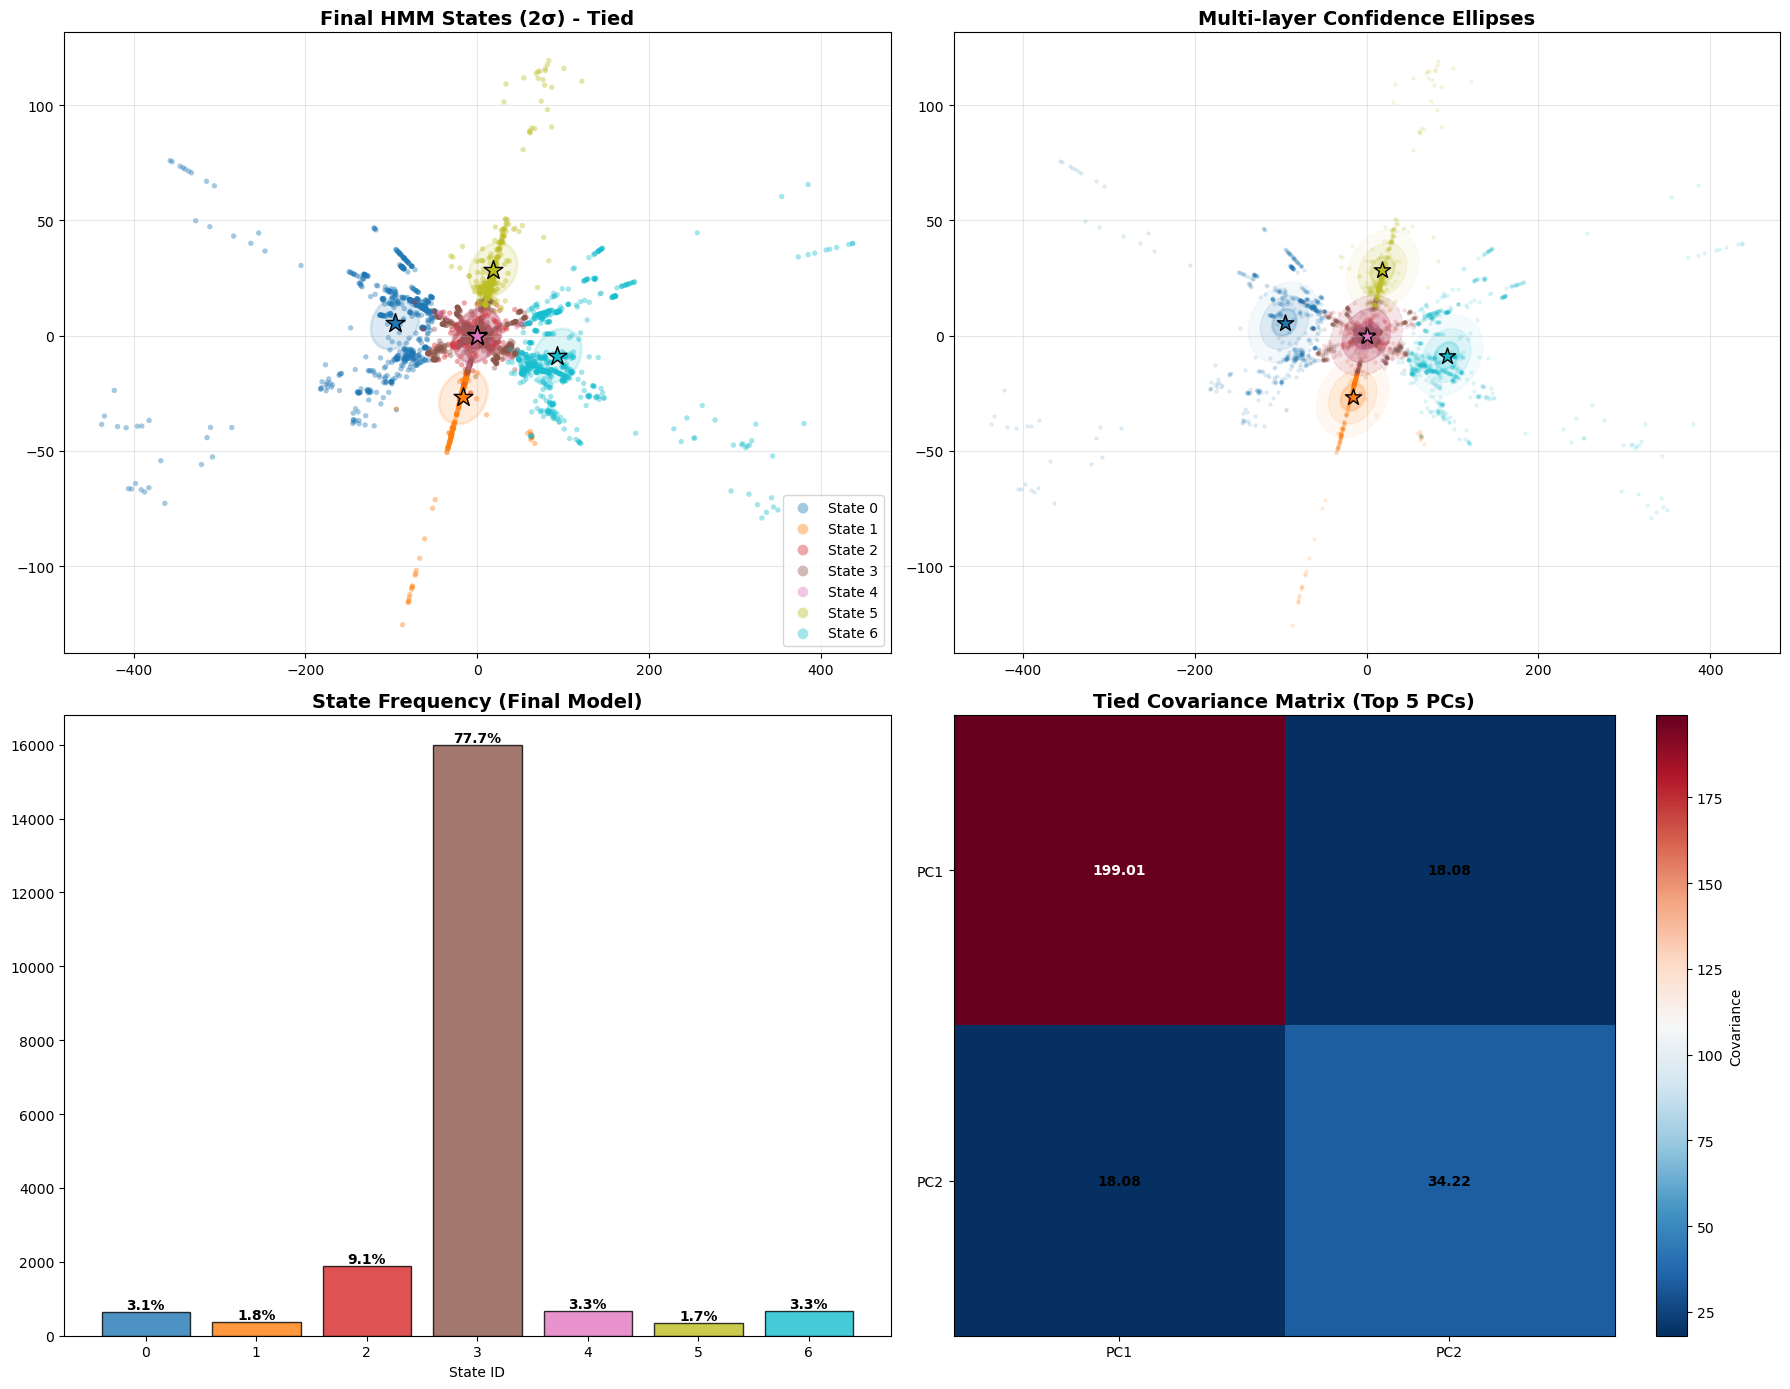

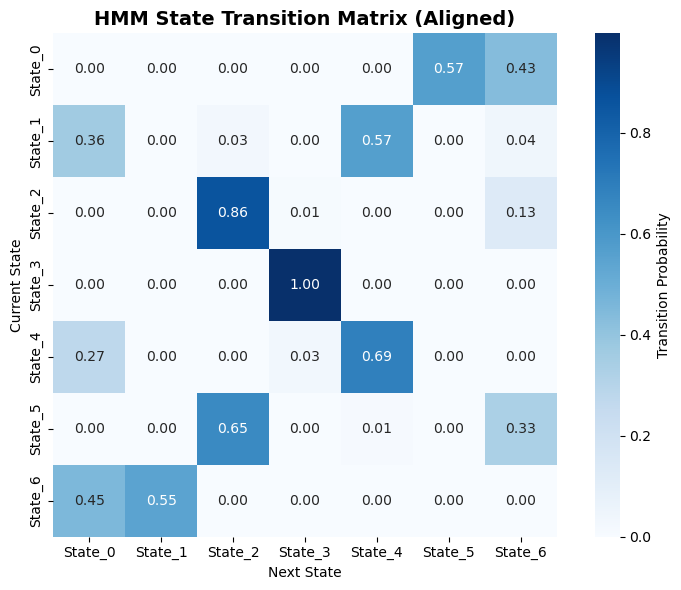

✔ 轉移矩陣已輸出: output_v全域版\hmm_transition_matrix_aligned.csv
✅ 完成！


In [7]:
# ============================================================
# Cell 8c: 擴充視窗 HMM (Expanding Window + Warm Start)
# ============================================================
# 策略變更：
# 1. 不再預先訓練全域模型。
# 2. 採用 Expanding Window：訓練資料隨著時間推進而不斷累積 (0 -> t)。
# 3. Warm Start：利用上個時刻的模型參數初始化當前模型，穩定狀態定義。
# 4. 輸出：
#    - Rolling State: 模擬當下視角，對未來(下一個Step)的預測。
#    - Final Global State: 訓練結束後，用最終模型回頭標記整段歷史。
# ============================================================

import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import polars as pl
from pathlib import Path
from tqdm.auto import tqdm
import copy



def log(msg): print(msg)

log("=" * 60)
log("【步驟 8c】擴充視窗 HMM (Expanding Window + Warm Start)")
log("=" * 60)

# ---------- 2. 讀取資料 ----------
log("\n【1. 讀取資料】")

out_pca_file = OUT / "step3_features_with_pca.parquet"
if not out_pca_file.exists():
    raise FileNotFoundError(f"找不到檔案: {out_pca_file}")

df_pca = pl.read_parquet(out_pca_file)

pca_cols = [c for c in df_pca.columns if c.startswith("PC")]
X_all = df_pca.select(pca_cols).fill_null(0.0).to_numpy().astype(np.float64)

log(f"✔ PCA 特徵：{pca_cols}")
log(f"✔ 樣本數：{len(X_all):,}")

# ---------- 3. 超參設定 ----------
N_STATES = 7
N_ITER_ROLLING = 100
TOL = 1e-4
COVARIANCE_TYPE = "tied"

log(f"✔ 隱狀態數：{N_STATES}")
log(f"✔ 協方差類型：{COVARIANCE_TYPE}")
log(f"✔ 訓練模式：Expanding Window (累積歷史資料)")

# ---------- 4. 滾動參數 ----------
TRADING_HOURS_PER_DAY = 5
MINUTES_PER_DAY = TRADING_HOURS_PER_DAY * 60          # 300
STEP_DAYS = 5
STEP_SIZE = STEP_DAYS * MINUTES_PER_DAY               # 1500
MIN_TRAIN_DAYS = 20
MIN_TRAIN_SIZE = MIN_TRAIN_DAYS * MINUTES_PER_DAY     # 6000

log(f"✔ 初始視窗: {MIN_TRAIN_SIZE} 筆 ({MIN_TRAIN_DAYS} 天)")
log(f"✔ 滾動步長: {STEP_SIZE} 筆 ({STEP_DAYS} 天)")

# ---------- 5. 擴充視窗訓練 ----------
log("\n" + "=" * 60)
log("【2. 開始滾動訓練】")
log("=" * 60)

rolling_states = np.full(len(X_all), -1, dtype=int)
prev_model = None
curr_idx = MIN_TRAIN_SIZE
total_steps = (len(X_all) - MIN_TRAIN_SIZE) // STEP_SIZE + 1

with tqdm(total=total_steps, desc="Expanding Training", unit="step") as pbar:
    while curr_idx < len(X_all):
        # 訓練區
        X_train = X_all[:curr_idx]
        # 預測區
        test_end = min(curr_idx + STEP_SIZE, len(X_all))
        X_test = X_all[curr_idx:test_end]
        if len(X_test) == 0:
            break

        # 建立模型
        curr_hmm = GaussianHMM(
            n_components=N_STATES,
            covariance_type=COVARIANCE_TYPE,
            n_iter=N_ITER_ROLLING,
            tol=TOL,
            random_state=42,
            verbose=0,
            init_params='stmc'
        )

        # Warm start
        if prev_model is not None:
            curr_hmm.init_params = ''
            curr_hmm.startprob_ = prev_model.startprob_.copy()
            curr_hmm.transmat_  = prev_model.transmat_.copy()
            curr_hmm.means_     = prev_model.means_.copy()
            prev_cov = prev_model.covars_
            if COVARIANCE_TYPE == 'tied' and prev_cov.ndim == 3:
                curr_hmm.covars_ = prev_cov[0].copy()
            else:
                curr_hmm.covars_ = prev_cov.copy()

        # 訓練
        try:
            curr_hmm.fit(X_train)
        except Exception as e:
            log(f"⚠ 訓練異常 (Index {curr_idx}): {e}")
            curr_idx += STEP_SIZE
            pbar.update(1)
            continue

        # 預測
        try:
            preds = curr_hmm.predict(X_test)
        except Exception as e:
            log(f"⚠ 預測異常 (Index {curr_idx}): {e}")
            curr_idx += STEP_SIZE
            pbar.update(1)
            continue

        # 狀態對齊 + 模型參數同步搬移
        means_pc1 = curr_hmm.means_[:, 0]
        if np.isnan(means_pc1).any():
            log(f"⚠ Means 含有 NaN，跳過此步 (Index {curr_idx})")
            curr_idx += STEP_SIZE
            pbar.update(1)
            continue
        sorted_indices = np.argsort(means_pc1)

        # 重新排列模型內部參數，使 state 0 永遠對應 PC1 最小
        curr_hmm.means_     = curr_hmm.means_[sorted_indices]
        curr_hmm.startprob_ = curr_hmm.startprob_[sorted_indices]
        curr_hmm.transmat_  = curr_hmm.transmat_[sorted_indices, :][:, sorted_indices]
        if COVARIANCE_TYPE != 'tied':
            curr_hmm.covars_ = curr_hmm.covars_[sorted_indices]

        # 現在 preds 已經是「對齊後」的狀態號，直接寫入
        rolling_states[curr_idx:test_end] = preds

        # 保存本輪模型
        prev_model = copy.deepcopy(curr_hmm)
        del curr_hmm
        curr_idx += STEP_SIZE
        pbar.update(1)

        # 定期 GC
        if curr_idx % (STEP_SIZE * 10) == 0:
            gc.collect()

log(f"✔ 滾動訓練完成")

# ---------- 6. 最終全域狀態 ----------
log("\n【3. 生成最終全域狀態】")
final_model = prev_model
if final_model is None:
    raise RuntimeError("模型訓練失敗，沒有產出任何模型。")

global_states_aligned = final_model.predict(X_all)
log(f"✔ 最終模型 Log-Likelihood: {final_model.score(X_all):.2f}")

# ---------- 7. 視覺化 ----------
log("\n【4. 產生視覺化報告】")


def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    if cov.ndim == 3:
        cov = cov[0]
    if cov.shape != (2, 2):
        return
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ell = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ell)


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
colors = plt.cm.tab10(np.linspace(0, 1, N_STATES))

# 準備繪圖資料
df_viz = df_pca.to_pandas().copy()
df_viz["State"] = global_states_aligned

# --- 圖 1: HMM States (2σ) ---
ax = axes[0, 0]
for s in range(N_STATES):
    mask = df_viz["State"] == s
    ax.scatter(df_viz.loc[mask, "PC1"], df_viz.loc[mask, "PC2"],
               c=[colors[s]], label=f"State {s}", s=15, alpha=0.4,
               edgecolors='none', rasterized=True)

# 繪橢圓
cov_base = final_model.covars_
if cov_base.ndim == 3:
    cov_base = cov_base[0]
cov_base = cov_base[:2, :2]
for s in range(N_STATES):
    m = final_model.means_[s, :2]
    plot_confidence_ellipse(m, cov_base, ax, n_std=2.0,
                            facecolor=colors[s], alpha=0.15, edgecolor=colors[s], linewidth=2)
    ax.scatter([m[0]], [m[1]], c=[colors[s]], s=200, marker='*', edgecolors='k', zorder=10)
ax.set_title(f"Final HMM States (2σ) - Tied", fontsize=14, fontweight='bold')
ax.legend(loc='best', markerscale=2)
ax.grid(alpha=0.3)

# --- 圖 2: Multi-layer Confidence ---
ax = axes[0, 1]
for s in range(N_STATES):
    mask = df_viz["State"] == s
    ax.scatter(df_viz.loc[mask, "PC1"], df_viz.loc[mask, "PC2"],
               c=[colors[s]], s=5, alpha=0.1, rasterized=True)
    m = final_model.means_[s, :2]
    plot_confidence_ellipse(m, cov_base, ax, n_std=3.0, facecolor=colors[s], alpha=0.05, edgecolor=colors[s], ls='--')
    plot_confidence_ellipse(m, cov_base, ax, n_std=2.0, facecolor=colors[s], alpha=0.1, edgecolor=colors[s])
    plot_confidence_ellipse(m, cov_base, ax, n_std=1.0, facecolor=colors[s], alpha=0.2, edgecolor=colors[s], lw=2)
    ax.scatter([m[0]], [m[1]], c=[colors[s]], s=150, marker='*', edgecolors='k')
ax.set_title("Multi-layer Confidence Ellipses", fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# --- 圖 3: 頻率分佈 ---
ax = axes[1, 0]
counts = df_viz["State"].value_counts().sort_index()
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='k', alpha=0.8)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, h, f'{h / len(df_viz):.1%}',
            ha='center', va='bottom', fontweight='bold')
ax.set_title("State Frequency (Final Model)", fontsize=14, fontweight='bold')
ax.set_xlabel("State ID")

# --- 圖 4: 協方差矩陣 ---
ax = axes[1, 1]
cov_mat = final_model.covars_
if cov_mat.ndim == 3:
    cov_mat = cov_mat[0]
cov_top = cov_mat[:5, :5]
im = ax.imshow(cov_top, cmap='RdBu_r', aspect='auto')
plt.colorbar(im, ax=ax, label="Covariance")
for i in range(cov_top.shape[0]):
    for j in range(cov_top.shape[1]):
        ax.text(j, i, f"{cov_top[i, j]:.2f}", ha="center", va="center",
                color="white" if abs(cov_top[i, j]) > np.max(cov_top) / 2 else "black", fontweight="bold")
ax.set_title("Tied Covariance Matrix (Top 5 PCs)", fontsize=14, fontweight='bold')
ax.set_xticks(range(cov_top.shape[1]))
ax.set_xticklabels([f"PC{i + 1}" for i in range(cov_top.shape[1])])
ax.set_yticks(range(cov_top.shape[0]))
ax.set_yticklabels([f"PC{i + 1}" for i in range(cov_top.shape[0])])

plt.tight_layout()
plt.savefig(OUT / "hmm_tied_expanding.png", dpi=300)
log(f"✔ 圖片已儲存: hmm_tied_expanding.png")
del df_viz, fig, axes
gc.collect()

# ---------- 8. 輸出與存檔 ----------
log("\n【5. 輸出結果與統計】")

df_final = df_pca.with_columns([
    pl.Series("HMM_State_Final", global_states_aligned).cast(pl.Int32),
    pl.Series("HMM_State_Rolling", rolling_states).cast(pl.Int32)
])

out_parquet = OUT / "step4_features_with_hmm.parquet"
df_final.write_parquet(out_parquet)

with open(OUT / "hmm_model_final.pkl", "wb") as f:
    pickle.dump(final_model, f)

# 統計表
target_features = ["Ret_t_scaled", "Buy_pressure_t_scaled", "Emo_score_scaled"]
available_features = [f for f in target_features if f in df_final.columns]
agg_exprs = [pl.len().alias("Count"), pl.col("PC1").mean().alias("PC1_Mean")]
for feat in available_features:
    agg_exprs.extend([
        pl.col(feat).mean().alias(f"{feat}_Mean"),
        pl.col(feat).median().alias(f"{feat}_Median"),
        pl.col(feat).std().alias(f"{feat}_Std")
    ])

stats = df_final.group_by("HMM_State_Final").agg(agg_exprs).sort("HMM_State_Final")
total_count = df_final.height
stats = stats.with_columns((pl.col("Count") / total_count).alias("Ratio"))

final_cols = (["HMM_State_Final", "Count", "Ratio"] +
              [c for c in stats.columns if c != "HMM_State_Final" and c != "Count" and c != "Ratio"])
out_stats_path = OUT / "hmm_state_stats.csv"
stats.select(final_cols).write_csv(out_stats_path, float_precision=4)

log(f"✔ Parquet 輸出: {out_parquet}")
log(f"✔ 統計數據輸出: {out_stats_path}")
print(stats.select(final_cols))

# ---------- 9. 轉移矩陣 ----------
log("\n【6. 計算狀態轉移機率矩陣】")
# 因模型內部已經是 aligned 順序，直接輸出即可
df_trans = pd.DataFrame(
    final_model.transmat_,
    index=[f"State_{i}" for i in range(N_STATES)],
    columns=[f"State_{i}" for i in range(N_STATES)]
)
print("Aligned Transition Matrix:")
print(df_trans.round(4))
out_trans_path = OUT / "hmm_transition_matrix_aligned.csv"
df_trans.to_csv(out_trans_path, float_format="%.6f")

plt.figure(figsize=(8, 6))
sns.heatmap(df_trans, annot=True, fmt=".2f", cmap="Blues", square=True,
            cbar_kws={"label": "Transition Probability"})
plt.title("HMM State Transition Matrix (Aligned)", fontsize=14, fontweight="bold")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.tight_layout()
plt.savefig(OUT / "hmm_transition_matrix_aligned.png", dpi=300)
plt.show()

log(f"✔ 轉移矩陣已輸出: {out_trans_path}")
log(f"✅ 完成！")

In [8]:
# ==========================================================
# 只壓縮 → 子序列比對 → NX 抓環
# ==========================================================
import numpy as np
import networkx as nx

log("\n【7. 壓縮比對】")

# ---- 清場 ----
for _v in ['up_cnt', 'down_cnt', 'total', 'simp_chain', 'G',
          'all_cycles', 'up_like', 'down_like']:
    if _v in locals():
        del locals()[_v]

# ---------- 1. 只壓縮連續相同（零平滑） ----------
def compress_states(seq):
    out = [seq[0]]
    for s in seq[1:]:
        if s != out[-1]:
            out.append(s)
    return np.array(out, dtype=int)

simp_chain = compress_states(rolling_states)     # 只壓一次

# ---------- 2. 子序列比對 ----------
def count_subseq_simp(simp_seq, core):
    k = len(core)
    hits = 0
    idx = 0
    n = len(simp_seq)
    while idx < n:
        ptr = 0
        for j in range(idx, n):
            if simp_seq[j] == core[ptr]:
                ptr += 1
                if ptr == k:
                    hits += 1
                    idx = j + 1     # 跳過這段，不重疊
                    break
        else:
            idx += 1
    return hits

# ---------- 3. 目標核心 ----------
up_core   = [3,5,6,2,3]
down_core = [3,1,0,4,3]

up_cnt   = count_subseq_simp(simp_chain, up_core)
down_cnt = count_subseq_simp(simp_chain, down_core)
total    = up_cnt + down_cnt

log(f"原始序列壓縮後長度：{len(simp_chain)} 段")
log(f"含「3-5-6-2-3」子順序：{up_cnt} 次")
log(f"含「3-1-0-4-3」子順序：{down_cnt} 次")
if total:
    log(f"兩者合計：{total} 次（多頭佔 {up_cnt/total:.1%}）")
else:
    log("兩者合計：0 次")

# ---------- 4. NetworkX 驗證（用 simp_chain） ----------
G = nx.DiGraph()
for st, nxt in zip(simp_chain[:-1], simp_chain[1:]):
    G.add_edge(st, nxt)

all_cycles = list(nx.simple_cycles(G))
up_like    = [c for c in all_cycles if np.isin([3,5,6,2,3], c).all()]
down_like  = [c for c in all_cycles if np.isin([3,1,0,4,3], c).all()]

log(f"NX 簡單環中，含 3-5-6-2-3 子順序：{len(up_like)} 個")
log(f"NX 簡單環中，含 3-1-0-4-3 子順序：{len(down_like)} 個")


【7. 壓縮比對】
原始序列壓縮後長度：1737 段
含「3-5-6-2-3」子順序：22 次
含「3-1-0-4-3」子順序：33 次
兩者合計：55 次（多頭佔 40.0%）
NX 簡單環中，含 3-5-6-2-3 子順序：414 個
NX 簡單環中，含 3-1-0-4-3 子順序：396 個


## 資料互動觀察

In [9]:
# ============================================================
# Cell 9: Viterbi 解碼與互動式體制視覺化 (Interactive)
# ============================================================
# 優化項目：
# 1. 保留 Viterbi 全域解碼邏輯。
# 2. 建立日期索引清單。
# 3. 引入 ipywidgets：提供 [上一日] [下一日] 按鈕與下拉選單。
# ============================================================

import matplotlib.dates as mdates
import polars as pl
import pandas as pd
import numpy as np
import pickle
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output

# 設定路徑 (假設上層已定義 OUT)
# OUT = Path("./output")

def log(msg): print(msg)

log("=" * 60)
log("【步驟 9】Viterbi 解碼 & 互動式檢視器")
log("=" * 60)

# ===============================================================
# ⚙️ 互動控制與全域狀態
# ===============================================================
VIEW_MODE = "day"
current_idx = 0


# =========== 1. 讀取資料 ===========
hmm_file = OUT / "step4_features_with_hmm.parquet"
if not hmm_file.exists():
    raise FileNotFoundError(f"❌ 找不到檔案: {hmm_file}")

log(f"1. 讀取檔案: {hmm_file.name}")
df_step4 = pl.read_parquet(hmm_file)

# 欄位映射
COL_TIME = "SnapshotTime"
COL_PRICE = "Price"
COL_DATE_GROUP = "date_group"
COL_PCS = ["PC1", "PC2"]

# 準備全量數據 (Viterbi 需要完整的序列)
X_all = df_step4.select(COL_PCS).fill_null(0.0).to_numpy()

# =========== 2. Viterbi 解碼 (只跑一次) ===========
model_path = OUT / "hmm_model_global.pkl"
if not model_path.exists():
    model_path = OUT / "hmm_model_tied.pkl" # Fallback

if not model_path.exists():
     # 如果都沒有，嘗試讀取 final
    model_path = OUT / "hmm_model_final.pkl"

if not model_path.exists():
     raise FileNotFoundError("❌ 找不到 HMM 模型檔案 (.pkl)")

log(f"2. 載入模型: {model_path.name}")
with open(model_path, "rb") as f:
    global_hmm = pickle.load(f)

N_STATES = global_hmm.n_components

# 判斷是否需要重新計算 Viterbi (如果欄位已存在且不想重算可跳過，這裡預設重算以確保一致)
log(f"⏳ 正在計算全量 Viterbi 路徑...")
log_prob, viterbi_states = global_hmm.decode(X_all, algorithm="viterbi")

# 狀態對齊 (Alignment)
means_pc1 = global_hmm.means_[:, 0]
sort_idx = np.argsort(means_pc1)
state_map = {old: new for new, old in enumerate(sort_idx)}
viterbi_aligned = np.array([state_map[s] for s in viterbi_states])

# 更新 DataFrame
df_final = df_step4.with_columns(
    pl.Series("HMM_State_Viterbi", viterbi_aligned).cast(pl.Int32)
)
# 存檔 (選擇性)
# df_final.write_parquet(hmm_file)
log(f"✔ Viterbi 解碼完成")

# =========== 3. 準備互動所需的資料 ===========

# 取得所有唯一的日期，並排序
all_dates = sorted(df_final[COL_DATE_GROUP].unique().to_list())
log(f"📅 資料總天數: {len(all_dates)} 天")
log(f"📅 日期範圍: {all_dates[0]} ~ {all_dates[-1]}")

# 預先定義顏色 (固定顏色避免跳動)
colors = plt.cm.tab10(np.linspace(0, 1, N_STATES))

# =========== 4. 定義繪圖函數 ===========
def plot_regime_by_date(date_idx):
    global VIEW_MODE

    if date_idx < 0 or date_idx >= len(all_dates):
        print("Index out of bounds.")
        return

    # === 決定要畫哪些日期 ===
    if VIEW_MODE == "day":
        date_list = [all_dates[date_idx]]
        title_suffix = f"Date: {all_dates[date_idx]}"
    else:
        start_idx = max(0, date_idx - 4)
        date_list = all_dates[start_idx:date_idx + 1]
        title_suffix = f"Week View: {date_list[0]} → {date_list[-1]}"

    # === 篩選資料（多日）===
    df_plot = df_final.filter(pl.col(COL_DATE_GROUP).is_in(date_list))
    if len(df_plot) == 0:
        print("No data.")
        return

    # === Pandas ===
    df_pd = df_plot.select(
        [COL_TIME, COL_PRICE, "HMM_State_Viterbi", COL_DATE_GROUP]
    ).to_pandas()

    df_pd[COL_TIME] = pd.to_datetime(df_pd[COL_TIME])
    df_pd = df_pd.sort_values(COL_TIME)

    # === MA（跨日 rolling，這是週視角的重點）===
    df_pd["MA5"]  = df_pd[COL_PRICE].rolling(5,  min_periods=1).mean()
    df_pd["MA10"] = df_pd[COL_PRICE].rolling(10, min_periods=1).mean()
    df_pd["MA30"] = df_pd[COL_PRICE].rolling(30, min_periods=1).mean()

    # === 繪圖 ===
    plt.close('all')
    fig, ax = plt.subplots(figsize=(16, 6))

    # 價格
    ax.plot(df_pd[COL_TIME], df_pd[COL_PRICE],
            color='black', lw=0.8, alpha=0.4, label="Price")

    # MA
    ax.plot(df_pd[COL_TIME], df_pd["MA5"],  color='orange', lw=1.2, label="MA5")
    ax.plot(df_pd[COL_TIME], df_pd["MA10"], color='green',  lw=1.2, label="MA10")
    ax.plot(df_pd[COL_TIME], df_pd["MA30"], color='red',    lw=1.2, label="MA30")

    # 狀態點
    for s in range(N_STATES):
        mask = df_pd["HMM_State_Viterbi"] == s
        if mask.any():
            ax.scatter(
                df_pd.loc[mask, COL_TIME],
                df_pd.loc[mask, COL_PRICE],
                s=22,
                color=colors[s],
                alpha=0.85,
                label=f"State {s}",
                zorder=10,
                edgecolors='none'
            )

    ax.set_title(
        f"Market Regimes (Viterbi) | {title_suffix}",
        fontsize=14, fontweight='bold'
    )
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend(
        loc='upper left',
        fontsize=9,
        ncol=min(N_STATES + 4, 7)
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.tight_layout()
    plt.show()



# =========== 5. 建立互動控制項 (ipywidgets) ===========

# 初始化索引 (預設最後一天)
current_idx = len(all_dates) - 1

# 建立元件
btn_prev = widgets.Button(description='◀ Previous Day', icon='arrow-left')
btn_next = widgets.Button(description='Next Day ▶', icon='arrow-right')
dropdown = widgets.Dropdown(
    options=[(date, i) for i, date in enumerate(all_dates)],
    value=current_idx,
    description='Select Date:',
)
out_plot = widgets.Output()

# 按鈕事件處理
def on_btn_click(b):
    global current_idx
    if b.description == '◀ Previous Day':
        current_idx = max(0, current_idx - 1)
    elif b.description == 'Next Day ▶':
        current_idx = min(len(all_dates) - 1, current_idx + 1)

    # 更新下拉選單的值 (會觸發 dropdown 的 observe)
    dropdown.value = current_idx

# 下拉選單事件處理
def on_dropdown_change(change):
    global current_idx
    if change['type'] == 'change' and change['name'] == 'value':
        current_idx = change['new']
        with out_plot:
            clear_output(wait=True)
            plot_regime_by_date(current_idx)

# 綁定事件
btn_prev.on_click(on_btn_click)
btn_next.on_click(on_btn_click)
dropdown.observe(on_dropdown_change)

# 初始顯示
with out_plot:
    plot_regime_by_date(current_idx)

# 顯示介面
log("\n⬇⬇⬇ 請使用下方控制項切換日期 ⬇⬇⬇")
ui = widgets.VBox([
    widgets.HBox([btn_prev, dropdown, btn_next]),
    out_plot
])
display(ui)

【步驟 9】Viterbi 解碼 & 互動式檢視器
1. 讀取檔案: step4_features_with_hmm.parquet
2. 載入模型: hmm_model_final.pkl
⏳ 正在計算全量 Viterbi 路徑...
✔ Viterbi 解碼完成
📅 資料總天數: 83 天
📅 日期範圍: 2025-09-05 ~ 2026-01-21



⬇⬇⬇ 請使用下方控制項切換日期 ⬇⬇⬇


## 狀態循環

【步驟 8d】Viterbi 路徑模式挖掘 (Pattern Mining)
✔ 載入狀態序列長度: 20,606
✔ 設定搜索窗口: 120 steps

正在分析: Path 1 (Mid->High) [3 -> ... -> 6]
  - 發現次數: 3629
  - 平均耗時: 59.8 steps
  - 最常見路徑: 3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->2->6 (0.7%)

正在分析: Path 2 (Mid->Low) [3 -> ... -> 0]
  - 發現次數: 3594
  - 平均耗時: 60.4 steps
  - 最常見路徑: 3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->2->6->0 (0.5%)

正在分析: Path 3 (High->Mid) [6 -> ... -> 3]
  - 發現次數: 466
  - 平均耗時: 54.2 steps
  - 最常見路徑: 6->1->4->3 (5.2%)

正在分析: Path 4 (Low->Mid) [0 -> ... -> 3]
  - 發現次數: 435
  - 平均耗時: 55.3 steps

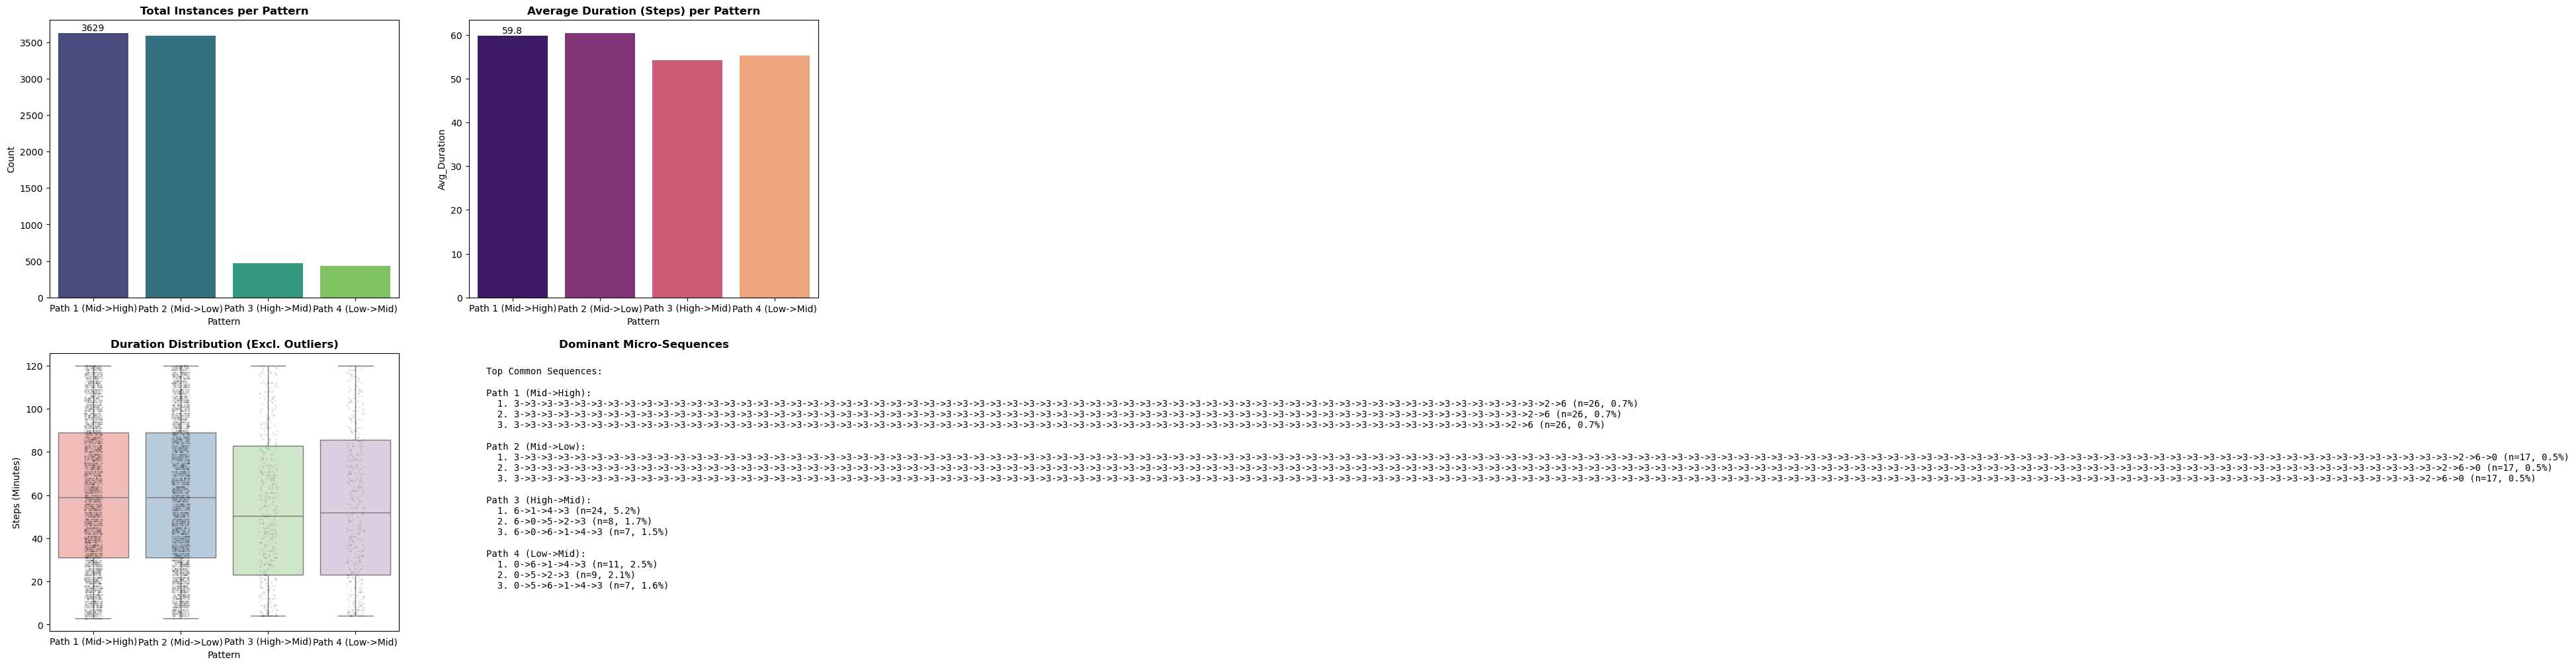

✅ 分析完成！


In [12]:
# ============================================================
# Cell 8d: Viterbi 路徑模式挖掘 (Pattern Mining)
# ============================================================
# 目標：從全域狀態序列中，挖掘特定的狀態轉移模式。
# 指定路徑：
#   1. Path A (3 -> 6): 中性轉高 (假設 State 6 為高)
#   2. Path B (3 -> 0): 中性轉低 (假設 State 0 為低)
#   3. Path C (6 -> 3): 高回歸中性
#   4. Path D (0 -> 3): 低回歸中性
# 分析維度：
#   - 發生次數 (Count)
#   - 平均耗時 (Duration)
#   - 最常見的中間路徑 (Most Common Intermediate Sequences)
# ============================================================

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# 設定路徑
out_parquet = OUT / "step4_features_with_hmm.parquet"

def log(msg): print(msg)

log("=" * 60)
log("【步驟 8d】Viterbi 路徑模式挖掘 (Pattern Mining)")
log("=" * 60)

# ---------- 1. 讀取資料 ----------
if not out_parquet.exists():
    raise FileNotFoundError(f"找不到檔案: {out_parquet}，請先執行 Cell 8c")

df = pl.read_parquet(out_parquet)
# 提取全域 Viterbi 序列
states = df["HMM_State_Final"].to_numpy()
timestamps = df["Date"].to_numpy() if "Date" in df.columns else np.arange(len(states))

log(f"✔ 載入狀態序列長度: {len(states):,}")

# ---------- 2. 定義路徑搜尋函數 ----------

def find_paths(state_seq, start_s, end_s, max_window=100):
    """
    搜尋從 start_s 開始，並在 max_window 步內首次抵達 end_s 的所有實例。
    回傳: list of dict (包含路徑、長度、起始索引)
    """
    found_paths = []
    n = len(state_seq)
    
    # 找出所有 start_s 的位置
    start_indices = np.where(state_seq == start_s)[0]
    
    for idx in start_indices:
        # 搜索窗口邊界
        search_end = min(idx + max_window, n)
        window = state_seq[idx + 1 : search_end]
        
        # 在窗口內尋找 end_s
        # np.where 回傳的是 tuple，取 [0]
        target_locs = np.where(window == end_s)[0]
        
        if len(target_locs) > 0:
            # 找到第一個 end_s
            first_target = target_locs[0]
            # 完整路徑包含 start 和 end
            # window[first_target] 就是 end_s，它的絕對索引是 idx + 1 + first_target
            end_idx = idx + 1 + first_target
            
            # 提取完整路徑
            full_path = state_seq[idx : end_idx + 1]
            
            found_paths.append({
                "start_idx": idx,
                "end_idx": end_idx,
                "duration": len(full_path),  # 包含頭尾的長度
                "sequence": tuple(full_path), #轉成 tuple 才能被 Hash 統計
                "mid_seq_str": "->".join(map(str, full_path))
            })
            
    return found_paths

# ---------- 3. 執行分析 ----------
# 定義您感興趣的 4 條路徑
# 假設 State 0=Low, 3=Mid, 6=High (依據之前 sorted PC1 邏輯)
target_patterns = [
    {"name": "Path 1 (Mid->High)", "start": 3, "end": 6},
    {"name": "Path 2 (Mid->Low)",  "start": 3, "end": 0},
    {"name": "Path 3 (High->Mid)", "start": 6, "end": 3},
    {"name": "Path 4 (Low->Mid)",  "start": 0, "end": 3},
]

MAX_WINDOW = 120 # 設定搜索窗口 (例如 120 分鐘/Bar)
results_summary = []
all_path_details = {}

log(f"✔ 設定搜索窗口: {MAX_WINDOW} steps")

for pattern in target_patterns:
    name = pattern["name"]
    s = pattern["start"]
    e = pattern["end"]
    
    log(f"\n正在分析: {name} [{s} -> ... -> {e}]")
    
    paths = find_paths(states, s, e, max_window=MAX_WINDOW)
    
    if not paths:
        log(f"  ⚠ 未發現任何實例")
        continue
        
    # 統計數據
    durations = [p["duration"] for p in paths]
    sequences = [p["mid_seq_str"] for p in paths]
    
    avg_dur = np.mean(durations)
    median_dur = np.median(durations)
    count = len(paths)
    
    # 找出最常見的具體走法 (Top 5)
    seq_counts = Counter(sequences).most_common(5)
    top_seq_str = seq_counts[0][0] if seq_counts else "N/A"
    top_seq_ratio = (seq_counts[0][1] / count) * 100 if seq_counts else 0
    
    log(f"  - 發現次數: {count}")
    log(f"  - 平均耗時: {avg_dur:.1f} steps")
    log(f"  - 最常見路徑: {top_seq_str} ({top_seq_ratio:.1f}%)")
    
    results_summary.append({
        "Pattern": name,
        "Start": s,
        "End": e,
        "Count": count,
        "Avg_Duration": avg_dur,
        "Median_Duration": median_dur,
        "Min_Duration": np.min(durations),
        "Max_Duration": np.max(durations),
        "Top_Sequence": top_seq_str,
        "Top_Seq_Count": seq_counts[0][1]
    })
    
    all_path_details[name] = {
        "durations": durations,
        "seq_counts": seq_counts
    }

# ---------- 4. 輸出統計表 ----------
if len(results_summary) > 0:
    df_res = pd.DataFrame(results_summary)
    print("\n【路徑分析摘要】")
    print(df_res[["Pattern", "Count", "Avg_Duration", "Top_Sequence"]].to_string(index=False))
    
    df_res.to_csv(OUT / "hmm_path_analysis_summary.csv", index=False)
else:
    log("沒有發現任何指定路徑。")

# ---------- 5. 視覺化 ----------
log("\n【產生視覺化圖表】")

if len(results_summary) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # 1. 各路徑發生次數比較
    ax = axes[0]
    sns.barplot(data=df_res, x="Pattern", y="Count", ax=ax, palette="viridis")
    ax.set_title("Total Instances per Pattern", fontsize=12, fontweight='bold')
    ax.bar_label(ax.containers[0])

    # 2. 各路徑平均耗時比較
    ax = axes[1]
    sns.barplot(data=df_res, x="Pattern", y="Avg_Duration", ax=ax, palette="magma")
    ax.set_title("Average Duration (Steps) per Pattern", fontsize=12, fontweight='bold')
    ax.bar_label(ax.containers[0], fmt='%.1f')

    # 3. 耗時分佈 (Boxplot)
    ax = axes[2]
    # 準備 Boxplot 數據
    plot_data = []
    for name, details in all_path_details.items():
        for d in details["durations"]:
            plot_data.append({"Pattern": name, "Duration": d})
    df_box = pd.DataFrame(plot_data)
    
    sns.boxplot(data=df_box, x="Pattern", y="Duration", ax=ax, palette="Pastel1", showfliers=False)
    sns.stripplot(data=df_box, x="Pattern", y="Duration", ax=ax, color='black', alpha=0.1, size=2, jitter=True)
    ax.set_title("Duration Distribution (Excl. Outliers)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Steps (Minutes)")

    # 4. Top 1 路徑的結構展示 (Text)
    ax = axes[3]
    ax.axis('off')
    text_content = "Top Common Sequences:\n\n"
    for name, details in all_path_details.items():
        top_s = details["seq_counts"]
        text_content += f"{name}:\n"
        for i, (seq, cnt) in enumerate(top_s[:3]):
            ratio = cnt / sum(v for k,v in details["seq_counts"]) # 這是粗略估計，分母應為總數
            total = results_summary[[r["Pattern"] for r in results_summary].index(name)]["Count"]
            text_content += f"  {i+1}. {seq} (n={cnt}, {cnt/total:.1%})\n"
        text_content += "\n"
    
    ax.text(0.05, 0.95, text_content, transform=ax.transAxes, fontsize=10, verticalalignment='top', fontfamily='monospace')
    ax.set_title("Dominant Micro-Sequences", fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUT / "hmm_path_patterns.png", dpi=300)
    log(f"✔ 圖表已儲存: hmm_path_patterns.png")
    plt.show()

log("✅ 分析完成！")

【步驟 8d】Viterbi 路徑模式挖掘 (Pattern Mining)
✔ 載入狀態序列長度: 20,606
✔ 設定搜索窗口: 120 steps

正在分析: Path 1 (Mid->High) [3 -> ... -> 6]
  - 發現次數: 3629
  - 平均耗時: 59.8 steps
  - 最常見路徑: 3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->2->6 (0.7%)

正在分析: Path 2 (Mid->Low) [3 -> ... -> 0]
  - 發現次數: 3594
  - 平均耗時: 60.4 steps
  - 最常見路徑: 3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->3->2->6->0 (0.5%)

正在分析: Path 3 (High->Mid) [6 -> ... -> 3]
  - 發現次數: 466
  - 平均耗時: 54.2 steps
  - 最常見路徑: 6->1->4->3 (5.2%)

正在分析: Path 4 (Low->Mid) [0 -> ... -> 3]
  - 發現次數: 435
  - 平均耗時: 55.3 steps

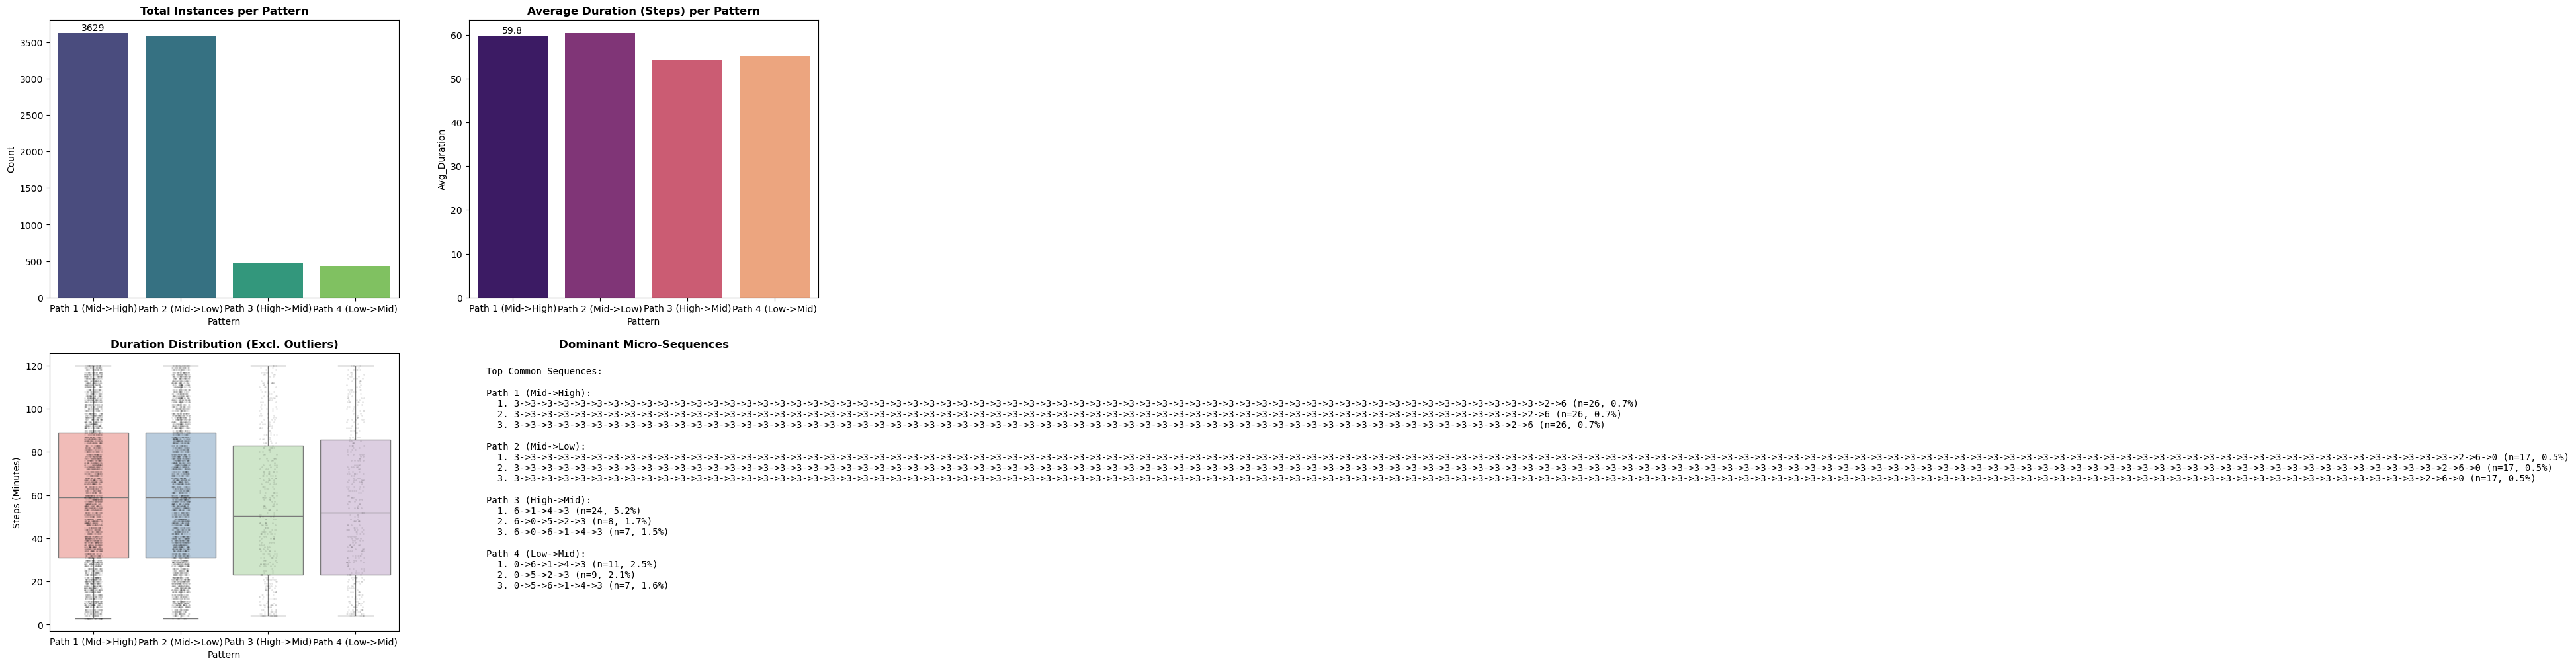

In [20]:
# ============================================================
# Cell 8d: Viterbi 路徑模式挖掘 (Pattern Mining)
# ============================================================
# 目標：從全域狀態序列中，挖掘特定的狀態轉移模式。
# 指定路徑：
#   1. Path A (3 -> 6): 中性轉高 (假設 State 6 為高)
#   2. Path B (3 -> 0): 中性轉低 (假設 State 0 為低)
#   3. Path C (6 -> 3): 高回歸中性
#   4. Path D (0 -> 3): 低回歸中性
# 分析維度：
#   - 發生次數 (Count)
#   - 平均耗時 (Duration)
#   - 最常見的中間路徑 (Most Common Intermediate Sequences)
# ============================================================

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# 設定路徑

out_parquet = OUT / "step4_features_with_hmm.parquet"

def log(msg): print(msg)

log("=" * 60)
log("【步驟 8d】Viterbi 路徑模式挖掘 (Pattern Mining)")
log("=" * 60)

# ---------- 1. 讀取資料 ----------
if not out_parquet.exists():
    raise FileNotFoundError(f"找不到檔案: {out_parquet}，請先執行 Cell 8c")

df = pl.read_parquet(out_parquet)
# 提取全域 Viterbi 序列
states = df["HMM_State_Final"].to_numpy()
timestamps = df["Date"].to_numpy() if "Date" in df.columns else np.arange(len(states))

log(f"✔ 載入狀態序列長度: {len(states):,}")

# ---------- 2. 定義路徑搜尋函數 ----------

def find_paths(state_seq, start_s, end_s, max_window=100):
    """
    搜尋從 start_s 開始，並在 max_window 步內首次抵達 end_s 的所有實例。
    回傳: list of dict (包含路徑、長度、起始索引)
    """
    found_paths = []
    n = len(state_seq)
    
    # 找出所有 start_s 的位置
    start_indices = np.where(state_seq == start_s)[0]
    
    for idx in start_indices:
        # 搜索窗口邊界
        search_end = min(idx + max_window, n)
        window = state_seq[idx + 1 : search_end]
        
        # 在窗口內尋找 end_s
        # np.where 回傳的是 tuple，取 [0]
        target_locs = np.where(window == end_s)[0]
        
        if len(target_locs) > 0:
            # 找到第一個 end_s
            first_target = target_locs[0]
            # 完整路徑包含 start 和 end
            # window[first_target] 就是 end_s，它的絕對索引是 idx + 1 + first_target
            end_idx = idx + 1 + first_target
            
            # 提取完整路徑
            full_path = state_seq[idx : end_idx + 1]
            
            found_paths.append({
                "start_idx": idx,
                "end_idx": end_idx,
                "duration": len(full_path),  # 包含頭尾的長度
                "sequence": tuple(full_path), #轉成 tuple 才能被 Hash 統計
                "mid_seq_str": "->".join(map(str, full_path))
            })
            
    return found_paths

# ---------- 3. 執行分析 ----------
# 定義您感興趣的 4 條路徑
# 假設 State 0=Low, 3=Mid, 6=High (依據之前 sorted PC1 邏輯)
target_patterns = [
    {"name": "Path 1 (Mid->High)", "start": 3, "end": 6},
    {"name": "Path 2 (Mid->Low)",  "start": 3, "end": 0},
    {"name": "Path 3 (High->Mid)", "start": 6, "end": 3},
    {"name": "Path 4 (Low->Mid)",  "start": 0, "end": 3},
]

MAX_WINDOW = 120 # 設定搜索窗口 (例如 120 分鐘/Bar)
results_summary = []
all_path_details = {}

log(f"✔ 設定搜索窗口: {MAX_WINDOW} steps")

for pattern in target_patterns:
    name = pattern["name"]
    s = pattern["start"]
    e = pattern["end"]
    
    log(f"\n正在分析: {name} [{s} -> ... -> {e}]")
    
    paths = find_paths(states, s, e, max_window=MAX_WINDOW)
    
    if not paths:
        log(f"  ⚠ 未發現任何實例")
        continue
        
    # 統計數據
    durations = [p["duration"] for p in paths]
    sequences = [p["mid_seq_str"] for p in paths]
    
    avg_dur = np.mean(durations)
    median_dur = np.median(durations)
    count = len(paths)
    
    # 找出最常見的具體走法 (Top 5)
    seq_counts = Counter(sequences).most_common(5)
    top_seq_str = seq_counts[0][0] if seq_counts else "N/A"
    top_seq_ratio = (seq_counts[0][1] / count) * 100 if seq_counts else 0
    
    log(f"  - 發現次數: {count}")
    log(f"  - 平均耗時: {avg_dur:.1f} steps")
    log(f"  - 最常見路徑: {top_seq_str} ({top_seq_ratio:.1f}%)")
    
    results_summary.append({
        "Pattern": name,
        "Start": s,
        "End": e,
        "Count": count,
        "Avg_Duration": avg_dur,
        "Median_Duration": median_dur,
        "Min_Duration": np.min(durations),
        "Max_Duration": np.max(durations),
        "Top_Sequence": top_seq_str,
        "Top_Seq_Count": seq_counts[0][1]
    })
    
    all_path_details[name] = {
        "durations": durations,
        "seq_counts": seq_counts
    }

# ---------- 4. 輸出統計表 ----------
if len(results_summary) > 0:
    df_res = pd.DataFrame(results_summary)
    print("\n【路徑分析摘要】")
    print(df_res[["Pattern", "Count", "Avg_Duration", "Top_Sequence"]].to_string(index=False))
    
    df_res.to_csv(OUT / "hmm_path_analysis_summary.csv", index=False)
else:
    log("沒有發現任何指定路徑。")

# ---------- 5. 視覺化 ----------
log("\n【產生視覺化圖表】")

if len(results_summary) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # 1. 各路徑發生次數比較
    ax = axes[0]
    sns.barplot(data=df_res, x="Pattern", y="Count", ax=ax, palette="viridis")
    ax.set_title("Total Instances per Pattern", fontsize=12, fontweight='bold')
    ax.bar_label(ax.containers[0])

    # 2. 各路徑平均耗時比較
    ax = axes[1]
    sns.barplot(data=df_res, x="Pattern", y="Avg_Duration", ax=ax, palette="magma")
    ax.set_title("Average Duration (Steps) per Pattern", fontsize=12, fontweight='bold')
    ax.bar_label(ax.containers[0], fmt='%.1f')

    # 3. 耗時分佈 (Boxplot) 



    ax = axes[2]
    # 準備 Boxplot 數據
    plot_data = []
    for name, details in all_path_details.items():
        for d in details["durations"]:
            plot_data.append({"Pattern": name, "Duration": d})
    df_box = pd.DataFrame(plot_data)
    
    sns.boxplot(data=df_box, x="Pattern", y="Duration", ax=ax, palette="Pastel1", showfliers=False)
    sns.stripplot(data=df_box, x="Pattern", y="Duration", ax=ax, color='black', alpha=0.1, size=2, jitter=True)
    ax.set_title("Duration Distribution (Excl. Outliers)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Steps (Minutes)")

    # 4. Top 1 路徑的結構展示 (Text)
    ax = axes[3]
    ax.axis('off')
    text_content = "Top Common Sequences:\n\n"
    for name, details in all_path_details.items():
        top_s = details["seq_counts"]
        text_content += f"{name}:\n"
        for i, (seq, cnt) in enumerate(top_s[:3]):
            ratio = cnt / sum(v for k,v in details["seq_counts"]) # 這是粗略估計，分母應為總數
            total = results_summary[[r["Pattern"] for r in results_summary].index(name)]["Count"]
            text_content += f"  {i+1}. {seq} (n={cnt}, {cnt/total:.1%})\n"
        text_content += "\n"
    
    ax.text(0.05, 0.95, text_content, transform=ax.transAxes, fontsize=10, verticalalignment='top', fontfamily='monospace')
    ax.set_title("Dominant Micro-Sequences", fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUT / "hmm_path_patterns.png", dpi=300)
    log(f"✔ 圖表已儲存: hmm_path_patterns.png")
    plt.show()

【步驟 8e】狀態績效評估 (State Performance Test)

【繪製狀態累積損益圖】
✔ 損益曲線已儲存: hmm_state_equity_curves.png

【各狀態未來回報統計 (Basis Points)】
 State  Count  AvgRet_1m_bps  AvgRet_5m_bps  AvgRet_15m_bps  AvgRet_30m_bps  AvgRet_60m_bps
     0    642           4.41           4.85            5.50            6.68            9.74
     1    368          -3.62          -2.43           -0.99            3.12           13.76
     2   1883           1.60           3.27            6.97           10.75           16.46
     3  16003           0.02           0.13            0.38            0.77            1.49
     4    676          -3.12          -4.89           -6.63           -6.97           -2.76
     5    357           3.54           3.53            4.56            6.46            9.01
     6    677          -4.11          -3.69           -2.76           -0.06            5.91
✔ 統計數據已儲存: hmm_state_performance.csv
✅ 完成！請觀察 State 6 是否為正回報(綠線向上)，State 0 是否為負回報(紅線向下)。


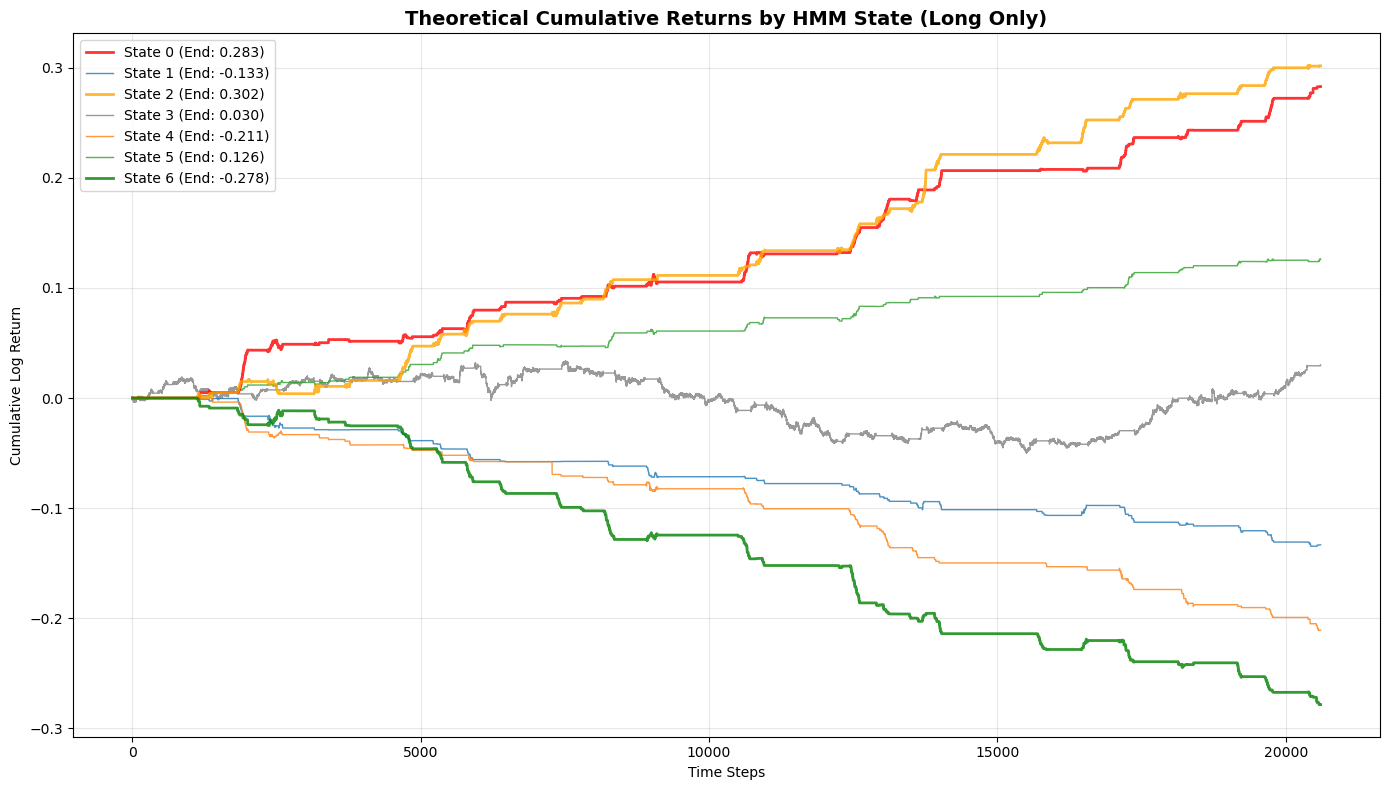

In [24]:
# ============================================================
# Cell 8e: 狀態績效評估 (State Performance / Event Study)
# ============================================================
# 目標：
# 1. 計算每個 HMM State 的「未來 N 分鐘累積報酬」。
# 2. 繪製各狀態的累積損益曲線 (Equity Curve)，判斷多空屬性。
# 3. 驗證 State 2 是否真的是「起漲點」，State 6 是否真的是「主升段」。
# ============================================================

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 設定路徑

out_parquet = OUT / "step4_features_with_hmm.parquet"

def log(msg): print(msg)

log("=" * 60)
log("【步驟 8e】狀態績效評估 (State Performance Test)")
log("=" * 60)

# ---------- 1. 讀取與準備資料 ----------
if not out_parquet.exists():
    raise FileNotFoundError(f"找不到檔案: {out_parquet}")

df = pl.read_parquet(out_parquet)

# 確保時間排序正確
df = df.sort("date_group")

# 假設 'Ret_t' 是當期回報 (Log Return or Percentage Return)
# 如果沒有，我們用 Close 計算
if "Ret_t" not in df.columns:
    log("⚠ 未發現 Ret_t，正在從 Close 計算...")
    df = df.with_columns(
        pl.col("Close").log().diff().fill_null(0).alias("Ret_t")
    )

# ---------- 2. 計算未來回報 (Future Returns) ----------
# 我們想看：當處於 State X 時，持有 1, 5, 15, 30 分鐘後的損益
offsets = [1, 5, 15, 30, 60]
exprs = []

# Shift(-k) 代表將未來的數據拉到當前行 (Peeking into future for analysis)
for k in offsets:
    # 未來 k 根 K 棒的累積回報 (Log returns are additive)
    exprs.append(
        pl.col("Ret_t").shift(-1).rolling_sum(window_size=k).shift(-(k-1)).alias(f"FwdRet_{k}m")
    )

df_perf = df.with_columns(exprs)

# ---------- 3. 統計各狀態的期望回報 ----------
states = sorted(df_perf["HMM_State_Final"].unique().to_list())
stats_list = []

for s in states:
    subset = df_perf.filter(pl.col("HMM_State_Final") == s)
    count = subset.height
    
    # 計算平均未來回報 (轉為 Basis Points: 1bp = 0.01%)
    # 使用 drop_nulls 避免尾部 NaN 影響計算
    means = [subset[f"FwdRet_{k}m"].drop_nulls().mean() * 10000 for k in offsets]
    # Win Rate: > 0 的比例
    wins = [(subset[f"FwdRet_{k}m"].drop_nulls() > 0).mean() for k in offsets]
    
    row = {"State": s, "Count": count, "Ratio": count/df.height}
    for i, k in enumerate(offsets):
        row[f"AvgRet_{k}m_bps"] = means[i]
        row[f"WinRate_{k}m"] = wins[i]
        
    stats_list.append(row)

df_stats = pl.DataFrame(stats_list)

# ---------- 4. 繪製累積損益曲線 (Equity Curves) ----------
# 這是最直觀的：假設我在該狀態一直持有 1 單位，資產會怎麼跑？
log("\n【繪製狀態累積損益圖】")

fig, ax = plt.subplots(figsize=(14, 8))

# 為了平滑，使用 cumsum
# 注意：這是一個理論曲線，假設只要在 State X 就持有 Long 部位，不在就平倉
for s in states:
    # 提取該狀態下的當期回報 (Ret_t)
    # 邏輯：If State[t] == s, then we HOLD during t -> t+1, earning Ret[t+1]
    
    # 1. 取得全域回報
    all_rets = df["Ret_t"].to_numpy()
    
    # 2. 取得訊號 mask (當前時刻是 State s)
    mask = (df["HMM_State_Final"] == s).to_numpy()
    
    # 3. 交易邏輯：看到 t 是 State s，則持有 t 到 t+1
    # 實際獲利是 Ret[t+1]，對應的是 mask[t]
    # 因此我們將 mask 向右 shift 1 格來與 Ret 對齊 (Signal at t affects Return at t+1)
    # 但在向量計算中，直接 mask[t] * Ret[t+1] 比較直觀，或者如下操作：
    
    # 簡單作法：Strategy Return = Ret * Signal.shift(1)
    # 這裡我們用 shift(1) 模擬「看到訊號下一根進場」或者「持有過夜」的概念
    # 但對於日內高頻，通常假設「當下狀態持續」，所以我們計算的是：
    # 該狀態發生期間的市場回報總和
    
    signal = np.roll(mask, 1) 
    signal[0] = 0 
    
    strat_rets = all_rets * signal
    equity_curve = np.cumsum(strat_rets)
    
    # 標示最終損益
    final_ret = equity_curve[-1]
    label = f"State {s} (End: {final_ret:.3f})"
    
    # 樣式區分
    # 假設 0=Low, 6=High, 2=Ignition
    if s == 0: 
        color = 'red'; lw = 2; zorder=10
    elif s == 6: 
        color = 'green'; lw = 2; zorder=10
    elif s == 2: 
        color = 'orange'; lw = 2; zorder=10
    elif s == 3:
        color = 'gray'; lw = 1; zorder=1
    else:
        color = None; lw = 1; zorder=5
        
    ax.plot(equity_curve, label=label, linewidth=lw, alpha=0.8, color=color, zorder=zorder)

ax.set_title("Theoretical Cumulative Returns by HMM State (Long Only)", fontsize=14, fontweight='bold')
ax.set_ylabel("Cumulative Log Return")
ax.set_xlabel("Time Steps")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT / "hmm_state_equity_curves.png", dpi=300)
log(f"✔ 損益曲線已儲存: hmm_state_equity_curves.png")

# ---------- 5. 輸出統計表格 ----------
log("\n【各狀態未來回報統計 (Basis Points)】")
# 整理顯示欄位
cols_show = ["State", "Count"] + [c for c in df_stats.columns if "AvgRet" in c]
print(df_stats.select(cols_show).to_pandas().round(2).to_string(index=False))

# 儲存
df_stats.write_csv(OUT / "hmm_state_performance.csv")
log(f"✔ 統計數據已儲存: hmm_state_performance.csv")

log("✅ 完成！請觀察 State 6 是否為正回報(綠線向上)，State 0 是否為負回報(紅線向下)。")